In [1]:
## Get dependencies ##

import string
import math
import sys
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sn
sys.path.append('..')
from GIR import *
import scipy as sp
import pickle
import time
import scipy as sp
from scipy import ndimage
from scipy import signal
import os
import statsmodels.api as sm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import glob
import requests
import ftplib
import PyPDF2
import io
import cmocean
import multiprocessing
import xarray as xr
import numpy as np
import pandas as pd
import requests
import xml.etree.ElementTree as ET
import zarr
import gcsfs
import multiprocessing

In [2]:
def esgf_search(server="https://esgf-node.llnl.gov/esg-search/search",
                files_type="OPENDAP", local_node=True, project="CMIP6",
                verbose=False,url_verbose=False, format="application%2Fsolr%2Bjson",
                use_csrf=False, **search):
    client = requests.session()
    payload = search
    payload["project"] = project
    payload["type"]= "File"
    if local_node:
        payload["distrib"] = "false"
    if use_csrf:
        client.get(server)
        if 'csrftoken' in client.cookies:
            # Django 1.6 and up
            csrftoken = client.cookies['csrftoken']
        else:
            # older versions
            csrftoken = client.cookies['csrf']
        payload["csrfmiddlewaretoken"] = csrftoken

    payload["format"] = format

    offset = 0
    numFound = 10000
    all_files = []
    files_type = files_type.upper()
    while offset < numFound:
        payload["offset"] = offset
        url_keys = [] 
        for k in payload:
            url_keys += ["{}={}".format(k, payload[k])]

        url = "{}/?{}".format(server, "&".join(url_keys))
        if url_verbose:
            print(url)
        r = client.get(url)
        r.raise_for_status()
        resp = r.json()["response"]
        numFound = int(resp["numFound"])
        resp = resp["docs"]
        offset += len(resp)
        for d in resp:
            if verbose:
                for k in d:
                    print("{}: {}".format(k,d[k]))
            url = d["url"]
            for f in d["url"]:
                sp = f.split("|")
                if sp[-1] == files_type:
                    all_files.append(sp[0].split(".html")[0])
    return sorted(all_files)

In [3]:
def get_annual_CMIP6_data_esgf(activity, table, variable, experiment, institution, source, member):
    # eg activity='CMIP', table='Amon', variable='tas', experiment='historical', institution="NCAR", source="CESM2", member="r10i1p1f1"
    
    result = esgf_search(activity_id=activity, table_id=table, variable_id=variable, experiment_id=experiment,institution_id=institution, source_id=source, member_id=member)
    
    if not result:
        print('No results for this request')
        return None
    
    # select results with only the latest datestamp:
    latest = sorted([x.split('/')[15] for x in result])[-1]
    result = [x for x in result if x.split('/')[15]==latest]
    
    # remove duplicate results
    result_1 = []

    for item in result:
        if item.split('/')[-1] in [x.split('/')[-1] for x in result_1]:
            continue
        else:
            result_1 += [item]

    ds = xr.open_mfdataset(result_1, combine='by_coords')
    
    files_area = esgf_search(variable_id='areacella', activity_id=activity, institution_id=institution, source_id=source)
    
    if not files_area:
        print('No areacella for this request')
        return None
    
    ds_area = xr.open_dataset(files_area[0])
    
    coords = list(ds[variable].coords.keys())
    if 'lat' in coords:
        dims = ['lat','lon']
    else:
        dims = ['latitude','longitude']
    
    total_area = ds_area.areacella.sum(dim=dims)
    ta_timeseries = (ds[variable] * ds_area.areacella).sum(dim=dims) / total_area
    
    return ta_timeseries.groupby('time.year').mean('time').to_pandas().rename(institution+'_'+source+'_'+member)

In [4]:
gs_stores = pd.read_csv('gs://cmip6/cmip6-zarr-consolidated-stores.csv')
gcs = gcsfs.GCSFileSystem(token='anon')
gs_stores.loc[:,'ism'] = gs_stores.loc[:,'institution_id'] + '_' + gs_stores.loc[:,'source_id'] + '_' + gs_stores.loc[:,'member_id']

def get_annual_CMIP6_data_gstore(activity, table, variable, experiment, institution, source, member):
    # eg activity='CMIP', table='Amon', variable='tas', experiment='historical', institution="NCAR", source="CESM2", member="r10i1p1f1"
    
    try:
    
        query = gs_stores.query("activity_id==\'"+activity+"\' & table_id==\'"+table+"\' & variable_id==\'"+variable+"\' & experiment_id==\'"+experiment+"\' & institution_id==\'"+institution+"\' & source_id==\'"+source+"\' & member_id==\'"+member+"\'")

        if query.empty:
            print('No results for this request')
            return None

        # create a mutable-mapping-style interface to the store
        mapper = gcs.get_mapper(query.zstore.values[0])

        # open it using xarray and zarr
        ds = xr.open_zarr(mapper, consolidated=True)

        dims = list(ds[variable].dims)
        dims.remove('time')

        lat_dim_name = [x for x in dims if 'lat' in x][0]

        weights = np.cos(np.deg2rad(ds[variable][lat_dim_name]))
        weights.name = "weights"

        ta_timeseries = ds[variable].weighted(weights).mean(dims)

        return ta_timeseries.groupby('time.year').mean('time').to_pandas().rename(institution+'_'+source+'_'+member+'_'+variable+'_'+experiment)
    
    except:
        print('retrieval failed')
        return None

/home/leachl/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [44]:
onepct_info = gs_stores.loc[(gs_stores.experiment_id=='1pctCO2')&(gs_stores.variable_id.isin(['tas','rlut','rsut','rsdt']))&(gs_stores.table_id=='Amon')]

onepct_data=[]

for index,row in onepct_info.iterrows():
    print('getting '+row.loc['ism']+'_'+row.loc['variable_id'])
    onepct_data += [get_annual_CMIP6_data_gstore(row.loc['activity_id'], row.loc['table_id'], row.loc['variable_id'], row.loc['experiment_id'], row.loc['institution_id'], row.loc['source_id'], row.loc['member_id'])]

getting AS-RCEC_TaiESM1_r1i1p1f1_rlut
getting AS-RCEC_TaiESM1_r1i1p1f1_rsut
getting AS-RCEC_TaiESM1_r1i1p1f1_tas
getting AWI_AWI-CM-1-1-MR_r1i1p1f1_rlut
getting AWI_AWI-CM-1-1-MR_r1i1p1f1_rsut
getting AWI_AWI-CM-1-1-MR_r1i1p1f1_tas
getting BCC_BCC-CSM2-MR_r1i1p1f1_rlut
getting BCC_BCC-CSM2-MR_r1i1p1f1_rsdt
getting BCC_BCC-CSM2-MR_r1i1p1f1_rsut
getting BCC_BCC-CSM2-MR_r1i1p1f1_tas
getting BCC_BCC-ESM1_r1i1p1f1_rlut
getting BCC_BCC-ESM1_r1i1p1f1_rsdt
getting BCC_BCC-ESM1_r1i1p1f1_rsut
getting BCC_BCC-ESM1_r1i1p1f1_tas
getting CAMS_CAMS-CSM1-0_r1i1p1f1_rlut
getting CAMS_CAMS-CSM1-0_r1i1p1f1_rsdt
getting CAMS_CAMS-CSM1-0_r1i1p1f1_rsut
getting CAMS_CAMS-CSM1-0_r1i1p1f1_tas
getting CAMS_CAMS-CSM1-0_r2i1p1f1_rlut
getting CAMS_CAMS-CSM1-0_r2i1p1f1_rsdt
getting CAMS_CAMS-CSM1-0_r2i1p1f1_rsut
getting CAMS_CAMS-CSM1-0_r2i1p1f1_tas
getting CAS_CAS-ESM2-0_r1i1p1f1_tas
getting CAS_FGOALS-f3-L_r1i1p1f1_rlut
getting CAS_FGOALS-f3-L_r1i1p1f1_rsut
getting CAS_FGOALS-f3-L_r1i1p1f1_tas
getting CAS_FGOALS-

/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


getting CSIRO-ARCCSS_ACCESS-CM2_r1i1p1f1_rsdt


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


getting CSIRO-ARCCSS_ACCESS-CM2_r1i1p1f1_rsut


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


getting CSIRO-ARCCSS_ACCESS-CM2_r1i1p1f1_tas


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


getting CSIRO_ACCESS-ESM1-5_r1i1p1f1_rlut


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


getting CSIRO_ACCESS-ESM1-5_r1i1p1f1_rsdt


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


getting CSIRO_ACCESS-ESM1-5_r1i1p1f1_rsut


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


getting CSIRO_ACCESS-ESM1-5_r1i1p1f1_tas


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


getting E3SM-Project_E3SM-1-0_r1i1p1f1_rlut
getting E3SM-Project_E3SM-1-0_r1i1p1f1_rsdt
getting E3SM-Project_E3SM-1-0_r1i1p1f1_rsut
getting E3SM-Project_E3SM-1-0_r1i1p1f1_tas
getting EC-Earth-Consortium_EC-Earth3-Veg_r1i1p1f1_rlut
getting EC-Earth-Consortium_EC-Earth3-Veg_r1i1p1f1_rsdt
getting EC-Earth-Consortium_EC-Earth3-Veg_r1i1p1f1_rsut
getting EC-Earth-Consortium_EC-Earth3-Veg_r1i1p1f1_tas
getting FIO-QLNM_FIO-ESM-2-0_r1i1p1f1_rlut
getting FIO-QLNM_FIO-ESM-2-0_r1i1p1f1_tas
getting FIO-QLNM_FIO-ESM-2-0_r2i1p1f1_tas
getting FIO-QLNM_FIO-ESM-2-0_r3i1p1f1_tas
getting HAMMOZ-Consortium_MPI-ESM-1-2-HAM_r1i1p1f1_tas
getting INM_INM-CM4-8_r1i1p1f1_rlut
getting INM_INM-CM4-8_r1i1p1f1_rsdt
getting INM_INM-CM4-8_r1i1p1f1_rsut
getting INM_INM-CM4-8_r1i1p1f1_tas
getting INM_INM-CM5-0_r1i1p1f1_rlut
getting INM_INM-CM5-0_r1i1p1f1_rsut
getting INM_INM-CM5-0_r1i1p1f1_tas
getting IPSL_IPSL-CM6A-LR_r1i1p1f1_rlut
getting IPSL_IPSL-CM6A-LR_r1i1p1f1_rsdt
getting IPSL_IPSL-CM6A-LR_r1i1p1f1_rsut
getting 

/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


getting MIROC_MIROC6_r1i1p1f1_rsdt


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


getting MIROC_MIROC6_r1i1p1f1_rsut


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


getting MIROC_MIROC6_r1i1p1f1_tas


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


getting MOHC_HadGEM3-GC31-LL_r1i1p1f3_rlut
getting MOHC_HadGEM3-GC31-LL_r1i1p1f3_rsdt
getting MOHC_HadGEM3-GC31-LL_r1i1p1f3_rsut
getting MOHC_HadGEM3-GC31-LL_r1i1p1f3_tas
getting MOHC_HadGEM3-GC31-LL_r2i1p1f3_rlut
getting MOHC_HadGEM3-GC31-LL_r2i1p1f3_rsdt
getting MOHC_HadGEM3-GC31-LL_r2i1p1f3_rsut
getting MOHC_HadGEM3-GC31-LL_r2i1p1f3_tas
getting MOHC_HadGEM3-GC31-LL_r3i1p1f3_rlut
getting MOHC_HadGEM3-GC31-LL_r3i1p1f3_rsdt
getting MOHC_HadGEM3-GC31-LL_r3i1p1f3_rsut
getting MOHC_HadGEM3-GC31-LL_r3i1p1f3_tas
getting MOHC_HadGEM3-GC31-LL_r4i1p1f3_rlut
getting MOHC_HadGEM3-GC31-LL_r4i1p1f3_rsdt
getting MOHC_HadGEM3-GC31-LL_r4i1p1f3_rsut
getting MOHC_HadGEM3-GC31-LL_r4i1p1f3_tas
getting MOHC_HadGEM3-GC31-MM_r1i1p1f3_rlut
getting MOHC_HadGEM3-GC31-MM_r1i1p1f3_rsut
getting MOHC_HadGEM3-GC31-MM_r1i1p1f3_tas
getting MOHC_UKESM1-0-LL_r1i1p1f2_rlut
getting MOHC_UKESM1-0-LL_r1i1p1f2_rsdt
getting MOHC_UKESM1-0-LL_r1i1p1f2_rsut
getting MOHC_UKESM1-0-LL_r1i1p1f2_tas
getting MOHC_UKESM1-0-LL_r2i1p1f2

In [45]:
pd.concat(onepct_data,axis=1).to_csv('./cmip6_data/onepct.csv')

In [46]:
abrupt_info = gs_stores.loc[(gs_stores.experiment_id=='abrupt-4xCO2')&(gs_stores.variable_id.isin(['tas','rlut','rsut','rsdt']))&(gs_stores.table_id=='Amon')]

abrupt_data=[]

for index,row in abrupt_info.iterrows():
    print('getting '+row.loc['ism']+'_'+row.loc['variable_id'])
    abrupt_data += [get_annual_CMIP6_data_gstore(row.loc['activity_id'], row.loc['table_id'], row.loc['variable_id'], row.loc['experiment_id'], row.loc['institution_id'], row.loc['source_id'], row.loc['member_id'])]

getting AS-RCEC_TaiESM1_r1i1p1f1_rlut
getting AS-RCEC_TaiESM1_r1i1p1f1_rsut
getting AS-RCEC_TaiESM1_r1i1p1f1_tas
getting AWI_AWI-CM-1-1-MR_r1i1p1f1_rlut
getting AWI_AWI-CM-1-1-MR_r1i1p1f1_rsdt
getting AWI_AWI-CM-1-1-MR_r1i1p1f1_rsut
getting AWI_AWI-CM-1-1-MR_r1i1p1f1_tas
getting BCC_BCC-CSM2-MR_r1i1p1f1_rlut
getting BCC_BCC-CSM2-MR_r1i1p1f1_rsdt
getting BCC_BCC-CSM2-MR_r1i1p1f1_rsut
getting BCC_BCC-CSM2-MR_r1i1p1f1_tas
getting BCC_BCC-ESM1_r1i1p1f1_rlut
getting BCC_BCC-ESM1_r1i1p1f1_rsdt
getting BCC_BCC-ESM1_r1i1p1f1_rsut
getting BCC_BCC-ESM1_r1i1p1f1_tas
getting CAMS_CAMS-CSM1-0_r1i1p1f1_rlut
getting CAMS_CAMS-CSM1-0_r1i1p1f1_rsdt
getting CAMS_CAMS-CSM1-0_r1i1p1f1_rsut
getting CAMS_CAMS-CSM1-0_r1i1p1f1_tas
getting CAMS_CAMS-CSM1-0_r2i1p1f1_rlut
getting CAMS_CAMS-CSM1-0_r2i1p1f1_rsdt
getting CAMS_CAMS-CSM1-0_r2i1p1f1_rsut
getting CAMS_CAMS-CSM1-0_r2i1p1f1_tas
getting CAS_CAS-ESM2-0_r1i1p1f1_tas
getting CAS_FGOALS-f3-L_r1i1p1f1_tas
getting CAS_FGOALS-f3-L_r2i1p1f1_tas
getting CAS_FGOALS

/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


getting CSIRO-ARCCSS_ACCESS-CM2_r1i1p1f1_rsdt


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


getting CSIRO-ARCCSS_ACCESS-CM2_r1i1p1f1_rsut


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


getting CSIRO-ARCCSS_ACCESS-CM2_r1i1p1f1_tas


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


getting CSIRO_ACCESS-ESM1-5_r1i1p1f1_rlut


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


getting CSIRO_ACCESS-ESM1-5_r1i1p1f1_rsdt


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


getting CSIRO_ACCESS-ESM1-5_r1i1p1f1_rsut


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


getting CSIRO_ACCESS-ESM1-5_r1i1p1f1_tas


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


getting E3SM-Project_E3SM-1-0_r1i1p1f1_rlut
getting E3SM-Project_E3SM-1-0_r1i1p1f1_rsdt
getting E3SM-Project_E3SM-1-0_r1i1p1f1_rsut
getting E3SM-Project_E3SM-1-0_r1i1p1f1_tas
getting EC-Earth-Consortium_EC-Earth3-Veg_r1i1p1f1_rlut
getting EC-Earth-Consortium_EC-Earth3-Veg_r1i1p1f1_rsdt
getting EC-Earth-Consortium_EC-Earth3-Veg_r1i1p1f1_rsut
getting EC-Earth-Consortium_EC-Earth3-Veg_r1i1p1f1_tas
getting EC-Earth-Consortium_EC-Earth3_r8i1p1f1_rlut
getting EC-Earth-Consortium_EC-Earth3_r8i1p1f1_rsdt
getting EC-Earth-Consortium_EC-Earth3_r8i1p1f1_rsut
getting EC-Earth-Consortium_EC-Earth3_r8i1p1f1_tas
getting FIO-QLNM_FIO-ESM-2-0_r1i1p1f1_rlut
getting FIO-QLNM_FIO-ESM-2-0_r1i1p1f1_tas
getting FIO-QLNM_FIO-ESM-2-0_r2i1p1f1_rlut
getting FIO-QLNM_FIO-ESM-2-0_r2i1p1f1_tas
getting FIO-QLNM_FIO-ESM-2-0_r3i1p1f1_rlut
getting FIO-QLNM_FIO-ESM-2-0_r3i1p1f1_tas
getting HAMMOZ-Consortium_MPI-ESM-1-2-HAM_r1i1p1f1_tas
getting INM_INM-CM4-8_r1i1p1f1_rlut
getting INM_INM-CM4-8_r1i1p1f1_rsdt
getting INM_I

/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


getting IPSL_IPSL-CM6A-LR_r1i1p1f1_rsdt
getting IPSL_IPSL-CM6A-LR_r1i1p1f1_rsut
getting IPSL_IPSL-CM6A-LR_r1i1p1f1_tas
getting IPSL_IPSL-CM6A-LR_r2i1p1f1_rlut
getting IPSL_IPSL-CM6A-LR_r2i1p1f1_rsdt
getting IPSL_IPSL-CM6A-LR_r2i1p1f1_rsut
getting IPSL_IPSL-CM6A-LR_r2i1p1f1_tas
getting IPSL_IPSL-CM6A-LR_r3i1p1f1_rlut
getting IPSL_IPSL-CM6A-LR_r3i1p1f1_rsdt
getting IPSL_IPSL-CM6A-LR_r3i1p1f1_rsut
getting IPSL_IPSL-CM6A-LR_r3i1p1f1_tas
getting IPSL_IPSL-CM6A-LR_r4i1p1f1_rlut
getting IPSL_IPSL-CM6A-LR_r4i1p1f1_rsdt
getting IPSL_IPSL-CM6A-LR_r4i1p1f1_rsut
getting IPSL_IPSL-CM6A-LR_r4i1p1f1_tas
getting IPSL_IPSL-CM6A-LR_r5i1p1f1_rlut
getting IPSL_IPSL-CM6A-LR_r5i1p1f1_rsdt
getting IPSL_IPSL-CM6A-LR_r5i1p1f1_rsut
getting IPSL_IPSL-CM6A-LR_r5i1p1f1_tas
getting IPSL_IPSL-CM6A-LR_r6i1p1f1_rlut
getting IPSL_IPSL-CM6A-LR_r6i1p1f1_rsdt
getting IPSL_IPSL-CM6A-LR_r6i1p1f1_rsut
getting IPSL_IPSL-CM6A-LR_r6i1p1f1_tas
getting IPSL_IPSL-CM6A-LR_r7i1p1f1_rlut
getting IPSL_IPSL-CM6A-LR_r7i1p1f1_rsdt
gettin

/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


getting MIROC_MIROC6_r1i1p1f1_rsdt


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


getting MIROC_MIROC6_r1i1p1f1_rsut


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


getting MIROC_MIROC6_r1i1p1f1_tas


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


getting MOHC_HadGEM3-GC31-LL_r1i1p1f3_rlut
getting MOHC_HadGEM3-GC31-LL_r1i1p1f3_rsdt
getting MOHC_HadGEM3-GC31-LL_r1i1p1f3_rsut
getting MOHC_HadGEM3-GC31-LL_r1i1p1f3_tas
getting MOHC_HadGEM3-GC31-MM_r1i1p1f3_rlut
getting MOHC_HadGEM3-GC31-MM_r1i1p1f3_rsdt
getting MOHC_HadGEM3-GC31-MM_r1i1p1f3_rsut
getting MOHC_HadGEM3-GC31-MM_r1i1p1f3_tas
getting MOHC_UKESM1-0-LL_r1i1p1f2_rlut
getting MOHC_UKESM1-0-LL_r1i1p1f2_rsdt
getting MOHC_UKESM1-0-LL_r1i1p1f2_rsut
getting MOHC_UKESM1-0-LL_r1i1p1f2_tas
getting MPI-M_MPI-ESM1-2-HR_r1i1p1f1_rlut
getting MPI-M_MPI-ESM1-2-HR_r1i1p1f1_rsdt
getting MPI-M_MPI-ESM1-2-HR_r1i1p1f1_rsut
getting MPI-M_MPI-ESM1-2-HR_r1i1p1f1_tas
getting MPI-M_MPI-ESM1-2-LR_r1i1p1f1_rlut
getting MPI-M_MPI-ESM1-2-LR_r1i1p1f1_rsdt
getting MPI-M_MPI-ESM1-2-LR_r1i1p1f1_rsut
getting MPI-M_MPI-ESM1-2-LR_r1i1p1f1_tas
getting MRI_MRI-ESM2-0_r10i1p1f1_rlut
getting MRI_MRI-ESM2-0_r10i1p1f1_rsdt
getting MRI_MRI-ESM2-0_r10i1p1f1_rsut
getting MRI_MRI-ESM2-0_r10i1p1f1_tas
getting MRI_MRI-ES

In [47]:
pd.concat(abrupt_data,axis=1).to_csv('./cmip6_data/abrupt-4xCO2.csv')

In [64]:
# piControl_info = gs_stores.loc[(gs_stores.experiment_id=='piControl')&(gs_stores.variable_id.isin(['tas','rlut','rsut','rsdt']))&(gs_stores.table_id=='Amon')]

# piControl_data=[]

for index,row in piControl_info.loc[26752:].iterrows():
    print('getting '+row.loc['ism']+'_'+row.loc['variable_id'])
    piControl_data += [get_annual_CMIP6_data_gstore(row.loc['activity_id'], row.loc['table_id'], row.loc['variable_id'], row.loc['experiment_id'], row.loc['institution_id'], row.loc['source_id'], row.loc['member_id'])]

getting EC-Earth-Consortium_EC-Earth3-LR_r1i1p1f1_rlut
retrieval failed
getting EC-Earth-Consortium_EC-Earth3-LR_r1i1p1f1_rsdt
retrieval failed
getting EC-Earth-Consortium_EC-Earth3-LR_r1i1p1f1_rsut
retrieval failed
getting EC-Earth-Consortium_EC-Earth3-LR_r1i1p1f1_tas


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


getting EC-Earth-Consortium_EC-Earth3-Veg-LR_r1i1p1f1_rsut


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


getting EC-Earth-Consortium_EC-Earth3-Veg-LR_r1i1p1f1_tas


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


getting EC-Earth-Consortium_EC-Earth3-Veg_r1i1p1f1_rlut


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


getting EC-Earth-Consortium_EC-Earth3-Veg_r1i1p1f1_rsdt


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


getting EC-Earth-Consortium_EC-Earth3-Veg_r1i1p1f1_rsut


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


getting EC-Earth-Consortium_EC-Earth3-Veg_r1i1p1f1_tas


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


getting EC-Earth-Consortium_EC-Earth3_r1i1p1f1_rlut


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


getting EC-Earth-Consortium_EC-Earth3_r1i1p1f1_rsdt


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


getting EC-Earth-Consortium_EC-Earth3_r1i1p1f1_rsut


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


retrieval failed
getting EC-Earth-Consortium_EC-Earth3_r1i1p1f1_tas


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


getting EC-Earth-Consortium_EC-Earth3_r2i1p1f1_rlut


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


getting EC-Earth-Consortium_EC-Earth3_r2i1p1f1_rsdt


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


getting EC-Earth-Consortium_EC-Earth3_r2i1p1f1_rsut


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


retrieval failed
getting EC-Earth-Consortium_EC-Earth3_r2i1p1f1_tas


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


getting FIO-QLNM_FIO-ESM-2-0_r1i1p1f1_rsut
getting FIO-QLNM_FIO-ESM-2-0_r1i1p1f1_tas
getting HAMMOZ-Consortium_MPI-ESM-1-2-HAM_r1i1p1f1_rlut


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


getting HAMMOZ-Consortium_MPI-ESM-1-2-HAM_r1i1p1f1_rsdt


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


getting HAMMOZ-Consortium_MPI-ESM-1-2-HAM_r1i1p1f1_rsut


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


retrieval failed
getting HAMMOZ-Consortium_MPI-ESM-1-2-HAM_r1i1p1f1_tas


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


getting INM_INM-CM4-8_r1i1p1f1_rlut
getting INM_INM-CM4-8_r1i1p1f1_rsdt
getting INM_INM-CM4-8_r1i1p1f1_rsut
getting INM_INM-CM4-8_r1i1p1f1_tas
getting INM_INM-CM5-0_r1i1p1f1_rlut
getting INM_INM-CM5-0_r1i1p1f1_rsdt
getting INM_INM-CM5-0_r1i1p1f1_rsut
getting INM_INM-CM5-0_r1i1p1f1_tas
getting IPSL_IPSL-CM6A-LR_r1i1p1f1_rlut


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


getting IPSL_IPSL-CM6A-LR_r1i1p1f1_rsdt


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


getting IPSL_IPSL-CM6A-LR_r1i1p1f1_rsut


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


getting IPSL_IPSL-CM6A-LR_r1i1p1f1_tas


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


getting IPSL_IPSL-CM6A-LR_r1i2p1f1_rlut
getting IPSL_IPSL-CM6A-LR_r1i2p1f1_rsdt
getting IPSL_IPSL-CM6A-LR_r1i2p1f1_rsut
getting IPSL_IPSL-CM6A-LR_r1i2p1f1_tas
getting MIROC_MIROC-ES2L_r1i1p1f2_rlut


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


getting MIROC_MIROC-ES2L_r1i1p1f2_rsdt


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


getting MIROC_MIROC-ES2L_r1i1p1f2_rsut


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


getting MIROC_MIROC-ES2L_r1i1p1f2_tas


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


getting MIROC_MIROC6_r1i1p1f1_rlut


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


getting MIROC_MIROC6_r1i1p1f1_rsdt


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


getting MIROC_MIROC6_r1i1p1f1_rsut


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


getting MIROC_MIROC6_r1i1p1f1_tas


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


getting MOHC_HadGEM3-GC31-LL_r1i1p1f1_rlut
getting MOHC_HadGEM3-GC31-LL_r1i1p1f1_rsdt
getting MOHC_HadGEM3-GC31-LL_r1i1p1f1_rsut
getting MOHC_HadGEM3-GC31-LL_r1i1p1f1_tas
getting MOHC_HadGEM3-GC31-MM_r1i1p1f1_rlut
getting MOHC_HadGEM3-GC31-MM_r1i1p1f1_rsdt
getting MOHC_HadGEM3-GC31-MM_r1i1p1f1_rsut
getting MOHC_HadGEM3-GC31-MM_r1i1p1f1_tas
getting MOHC_UKESM1-0-LL_r1i1p1f2_rlut
getting MOHC_UKESM1-0-LL_r1i1p1f2_rsdt
getting MOHC_UKESM1-0-LL_r1i1p1f2_rsut
getting MOHC_UKESM1-0-LL_r1i1p1f2_tas
getting MPI-M_MPI-ESM1-2-HR_r1i1p1f1_rlut


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


getting MPI-M_MPI-ESM1-2-HR_r1i1p1f1_rsdt


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


getting MPI-M_MPI-ESM1-2-HR_r1i1p1f1_rsut


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


getting MPI-M_MPI-ESM1-2-HR_r1i1p1f1_tas


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


getting MPI-M_MPI-ESM1-2-LR_r1i1p1f1_rlut


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


getting MPI-M_MPI-ESM1-2-LR_r1i1p1f1_rsdt


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


getting MPI-M_MPI-ESM1-2-LR_r1i1p1f1_rsut


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


getting MPI-M_MPI-ESM1-2-LR_r1i1p1f1_tas


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


getting MPI-M_MPI-ESM1-2-LR_r2i1p1f1_rlut
getting MPI-M_MPI-ESM1-2-LR_r2i1p1f1_rsdt
getting MPI-M_MPI-ESM1-2-LR_r2i1p1f1_rsut
getting MPI-M_MPI-ESM1-2-LR_r2i1p1f1_tas
getting MRI_MRI-ESM2-0_r1i1p1f1_rlut
getting MRI_MRI-ESM2-0_r1i1p1f1_rsdt
getting MRI_MRI-ESM2-0_r1i1p1f1_rsut
getting MRI_MRI-ESM2-0_r1i1p1f1_tas
getting MRI_MRI-ESM2-0_r1i2p1f1_rlut
getting MRI_MRI-ESM2-0_r1i2p1f1_rsdt
getting MRI_MRI-ESM2-0_r1i2p1f1_rsut
getting MRI_MRI-ESM2-0_r1i2p1f1_tas
getting NASA-GISS_GISS-E2-1-G-CC_r1i1p1f1_rlut
getting NASA-GISS_GISS-E2-1-G-CC_r1i1p1f1_rsdt
getting NASA-GISS_GISS-E2-1-G-CC_r1i1p1f1_rsut
getting NASA-GISS_GISS-E2-1-G-CC_r1i1p1f1_tas
getting NASA-GISS_GISS-E2-1-G_r101i1p1f1_rlut
getting NASA-GISS_GISS-E2-1-G_r101i1p1f1_rsdt
getting NASA-GISS_GISS-E2-1-G_r101i1p1f1_rsut
getting NASA-GISS_GISS-E2-1-G_r101i1p1f1_tas
getting NASA-GISS_GISS-E2-1-G_r102i1p1f1_rlut
getting NASA-GISS_GISS-E2-1-G_r102i1p1f1_rsdt
getting NASA-GISS_GISS-E2-1-G_r102i1p1f1_rsut
getting NASA-GISS_GISS-E2-1-G_r

/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


getting NUIST_NESM3_r1i1p1f1_rsdt


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


getting NUIST_NESM3_r1i1p1f1_rsut


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


getting NUIST_NESM3_r1i1p1f1_tas


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


getting SNU_SAM0-UNICON_r1i1p1f1_rlut
getting SNU_SAM0-UNICON_r1i1p1f1_rsdt
getting SNU_SAM0-UNICON_r1i1p1f1_rsut
getting SNU_SAM0-UNICON_r1i1p1f1_tas
getting THU_CIESM_r1i1p1f1_rlut
getting THU_CIESM_r1i1p1f1_rsut
getting THU_CIESM_r1i1p1f1_tas
getting UA_MCM-UA-1-0_r1i1p1f1_rlut
getting UA_MCM-UA-1-0_r1i1p1f1_tas


In [68]:
pd.concat(piControl_data,axis=1)#.to_csv('./cmip6_data/piControl.csv')

,AS-RCEC_TaiESM1_r1i1p1f1_rlut_piControl,AS-RCEC_TaiESM1_r1i1p1f1_rsdt_piControl,AS-RCEC_TaiESM1_r1i1p1f1_rsut_piControl,AS-RCEC_TaiESM1_r1i1p1f1_tas_piControl,AWI_AWI-CM-1-1-MR_r1i1p1f1_rlut_piControl,AWI_AWI-CM-1-1-MR_r1i1p1f1_rsdt_piControl,AWI_AWI-CM-1-1-MR_r1i1p1f1_rsut_piControl,AWI_AWI-CM-1-1-MR_r1i1p1f1_tas_piControl,AWI_AWI-ESM-1-1-LR_r1i1p1f1_rlut_piControl,AWI_AWI-ESM-1-1-LR_r1i1p1f1_rsdt_piControl,...,NUIST_NESM3_r1i1p1f1_tas_piControl,SNU_SAM0-UNICON_r1i1p1f1_rlut_piControl,SNU_SAM0-UNICON_r1i1p1f1_rsdt_piControl,SNU_SAM0-UNICON_r1i1p1f1_rsut_piControl,SNU_SAM0-UNICON_r1i1p1f1_tas_piControl,THU_CIESM_r1i1p1f1_rlut_piControl,THU_CIESM_r1i1p1f1_rsut_piControl,THU_CIESM_r1i1p1f1_tas_piControl,UA_MCM-UA-1-0_r1i1p1f1_rlut_piControl,UA_MCM-UA-1-0_r1i1p1f1_tas_piControl
year,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,239.733699,340.255945,99.093400,286.443988,238.297752,99.629425,287.442646,236.211120,286.627679
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,239.785330,340.255945,99.236269,286.455807,237.707992,99.515046,287.395520,236.050251,286.624886
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,239.303222,340.255945,99.008129,286.355158,238.188282,99.093707,287.237164,235.778744,286.535365
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,239.485249,340.255945,99.087453,286.369920,238.684758,99.138385,287.292015,235.929275,286.624112
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,239.179624,340.255945,99.294687,286.261834,238.582403,99.193333,287.388300,236.302278,286.838261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7890,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7891,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7892,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# ssp_list = ['ssp370', 'ssp126', 'ssp245', 'ssp585', 'ssp119', 'ssp434', 'ssp460', 'ssp534-over']
# ssp_info = gs_stores.loc[(gs_stores.experiment_id.isin(ssp_list))&(gs_stores.variable_id=='tas')&(gs_stores.table_id=='Amon')]

# ssp_data=[]

for index,row in ssp_info.iterrows():
    print('getting '+row.loc['ism']+'_'+row.loc['variable_id'])
    ssp_data += [get_annual_CMIP6_data_gstore(row.loc['activity_id'], row.loc['table_id'], row.loc['variable_id'], row.loc['experiment_id'], row.loc['institution_id'], row.loc['source_id'], row.loc['member_id'])]

getting MRI_MRI-ESM2-0_r1i1p1f1_tas
getting MRI_MRI-ESM2-0_r1i2p1f1_tas
getting NASA-GISS_GISS-E2-1-G_r3i1p3f1_tas


In [23]:
pd.concat(ssp_data,axis=1).to_csv('./cmip6_data/ssp_tas.csv')

In [90]:
# hist_info = gs_stores.loc[(gs_stores.experiment_id=='historical')&(gs_stores.variable_id=='tas')&(gs_stores.table_id=='Amon')]

# hist_data=[]

for index,row in hist_info.iloc[[i for i,x in enumerate(hist_data) if x is None]].iterrows():
    print('getting '+row.loc['ism']+'_'+row.loc['variable_id'])
    hist_data += [get_annual_CMIP6_data_gstore(row.loc['activity_id'], row.loc['table_id'], row.loc['variable_id'], row.loc['experiment_id'], row.loc['institution_id'], row.loc['source_id'], row.loc['member_id'])]

getting AWI_AWI-CM-1-1-MR_r2i1p1f1_tas
getting CAMS_CAMS-CSM1-0_r1i1p1f2_tas
getting CNRM-CERFACS_CNRM-CM6-1-HR_r1i1p1f2_tas
getting CNRM-CERFACS_CNRM-CM6-1_r10i1p1f2_tas
getting EC-Earth-Consortium_EC-Earth3-Veg_r2i1p1f1_tas
getting EC-Earth-Consortium_EC-Earth3-Veg_r5i1p1f1_tas
getting MIROC_MIROC6_r33i1p1f1_tas
getting MIROC_MIROC6_r34i1p1f1_tas
getting NCAR_CESM2_r7i1p1f1_tas
getting NCAR_CESM2_r8i1p1f1_tas


In [95]:
pd.concat(hist_data,axis=1).to_csv('./cmip6_data/hist_tas.csv')

In [5]:
def get_annual_CMIP6_data_gstore_co2(activity, table, variable, experiment, institution, source, member):
    # eg activity='CMIP', table='Amon', variable='tas', experiment='historical', institution="NCAR", source="CESM2", member="r10i1p1f1"
    
    try:
    
        query = gs_stores.query("activity_id==\'"+activity+"\' & table_id==\'"+table+"\' & variable_id==\'"+variable+"\' & experiment_id==\'"+experiment+"\' & institution_id==\'"+institution+"\' & source_id==\'"+source+"\' & member_id==\'"+member+"\'")

        if query.empty:
            print('No results for this request')
            return None

        # create a mutable-mapping-style interface to the store
        mapper = gcs.get_mapper(query.zstore.values[0])

        # open it using xarray and zarr
        ds = xr.open_zarr(mapper, consolidated=True)

        dims = list(ds[variable].dims)
        dims.remove('time')

        lat_dim_name = [x for x in dims if 'lat' in x][0]

        weights = np.cos(np.deg2rad(ds[variable][lat_dim_name]))
        weights.name = "weights"

        ta_timeseries = ds[variable].isel(plev=0).weighted(weights).mean(dims)

        return ta_timeseries.groupby('time.year').mean('time').to_pandas().rename(institution+'_'+source+'_'+member+'_'+variable+'_'+experiment)
    
    except:
        print('retrieval failed')
        return None

In [13]:
co2_info = gs_stores.loc[(gs_stores.experiment_id.isin(['abrupt-4xCO2','1pctCO2','historical','piControl']))&(gs_stores.variable_id=='co2')&(gs_stores.table_id=='Amon')]

co2_data=[]

for index,row in co2_info.iterrows():
    print('getting '+row.loc['ism']+'_'+row.loc['variable_id'])
    co2_data += [get_annual_CMIP6_data_gstore_co2(row.loc['activity_id'], row.loc['table_id'], row.loc['variable_id'], row.loc['experiment_id'], row.loc['institution_id'], row.loc['source_id'], row.loc['member_id'])]

getting BCC_BCC-CSM2-MR_r1i1p1f1_co2
getting BCC_BCC-CSM2-MR_r1i1p1f1_co2
getting BCC_BCC-CSM2-MR_r1i1p1f1_co2
getting BCC_BCC-CSM2-MR_r2i1p1f1_co2
getting BCC_BCC-CSM2-MR_r3i1p1f1_co2
getting BCC_BCC-ESM1_r1i1p1f1_co2
getting BCC_BCC-ESM1_r2i1p1f1_co2
getting BCC_BCC-ESM1_r3i1p1f1_co2
getting CNRM-CERFACS_CNRM-ESM2-1_r1i1p1f2_co2
getting CNRM-CERFACS_CNRM-ESM2-1_r2i1p1f2_co2
getting CNRM-CERFACS_CNRM-ESM2-1_r3i1p1f2_co2
getting CNRM-CERFACS_CNRM-ESM2-1_r4i1p1f2_co2
getting CNRM-CERFACS_CNRM-ESM2-1_r1i1p1f2_co2
getting CNRM-CERFACS_CNRM-ESM2-1_r2i1p1f2_co2
getting CNRM-CERFACS_CNRM-ESM2-1_r3i1p1f2_co2
getting CNRM-CERFACS_CNRM-ESM2-1_r1i1p1f2_co2
getting CNRM-CERFACS_CNRM-ESM2-1_r2i1p1f2_co2
getting CNRM-CERFACS_CNRM-ESM2-1_r3i1p1f2_co2
getting CNRM-CERFACS_CNRM-ESM2-1_r4i1p1f2_co2
getting CNRM-CERFACS_CNRM-ESM2-1_r5i1p1f2_co2
getting CNRM-CERFACS_CNRM-ESM2-1_r1i1p1f2_co2
getting MRI_MRI-ESM2-0_r1i1p1f1_co2
getting MRI_MRI-ESM2-0_r10i1p1f1_co2
getting MRI_MRI-ESM2-0_r11i1p1f1_co2
getti

In [14]:
pd.concat(co2_data,axis=1).to_csv('./cmip6_data/co2.csv')

In [15]:
def get_annual_CMIP6_data_gstore_co2mass(activity, table, variable, experiment, institution, source, member):
    # eg activity='CMIP', table='Amon', variable='tas', experiment='historical', institution="NCAR", source="CESM2", member="r10i1p1f1"
    
    try:
    
        query = gs_stores.query("activity_id==\'"+activity+"\' & table_id==\'"+table+"\' & variable_id==\'"+variable+"\' & experiment_id==\'"+experiment+"\' & institution_id==\'"+institution+"\' & source_id==\'"+source+"\' & member_id==\'"+member+"\'")

        if query.empty:
            print('No results for this request')
            return None

        # create a mutable-mapping-style interface to the store
        mapper = gcs.get_mapper(query.zstore.values[0])

        # open it using xarray and zarr
        ds = xr.open_zarr(mapper, consolidated=True)

        return ds[variable].groupby('time.year').mean('time').to_pandas().rename(institution+'_'+source+'_'+member+'_'+variable+'_'+experiment)
    
    except:
        print('retrieval failed')
        return None

In [16]:
co2mass_info = gs_stores.loc[(gs_stores.experiment_id.isin(['abrupt-4xCO2','1pctCO2','historical','piControl']))&(gs_stores.variable_id=='co2mass')&(gs_stores.table_id=='Amon')]

co2mass_data=[]

for index,row in co2mass_info.iterrows():
    print('getting '+row.loc['ism']+'_'+row.loc['variable_id'])
    co2mass_data += [get_annual_CMIP6_data_gstore_co2mass(row.loc['activity_id'], row.loc['table_id'], row.loc['variable_id'], row.loc['experiment_id'], row.loc['institution_id'], row.loc['source_id'], row.loc['member_id'])]

getting AS-RCEC_TaiESM1_r1i1p1f1_co2mass
getting AS-RCEC_TaiESM1_r1i1p1f1_co2mass
getting CNRM-CERFACS_CNRM-CM6-1-HR_r1i1p1f2_co2mass
getting CNRM-CERFACS_CNRM-CM6-1-HR_r1i1p1f2_co2mass
getting CNRM-CERFACS_CNRM-CM6-1_r1i1p1f2_co2mass
getting CNRM-CERFACS_CNRM-CM6-1_r1i1p1f2_co2mass
getting CNRM-CERFACS_CNRM-CM6-1_r2i1p1f2_co2mass
getting CNRM-CERFACS_CNRM-CM6-1_r3i1p1f2_co2mass
getting CNRM-CERFACS_CNRM-CM6-1_r4i1p1f2_co2mass
getting CNRM-CERFACS_CNRM-CM6-1_r5i1p1f2_co2mass
getting CNRM-CERFACS_CNRM-CM6-1_r6i1p1f2_co2mass
getting IPSL_IPSL-CM6A-LR_r1i1p1f1_co2mass
getting IPSL_IPSL-CM6A-LR_r10i1p1f1_co2mass
getting IPSL_IPSL-CM6A-LR_r11i1p1f1_co2mass
getting IPSL_IPSL-CM6A-LR_r12i1p1f1_co2mass
getting IPSL_IPSL-CM6A-LR_r1i1p1f1_co2mass


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


getting IPSL_IPSL-CM6A-LR_r2i1p1f1_co2mass
getting IPSL_IPSL-CM6A-LR_r3i1p1f1_co2mass
getting IPSL_IPSL-CM6A-LR_r4i1p1f1_co2mass
getting IPSL_IPSL-CM6A-LR_r5i1p1f1_co2mass
getting IPSL_IPSL-CM6A-LR_r6i1p1f1_co2mass
getting IPSL_IPSL-CM6A-LR_r7i1p1f1_co2mass
getting IPSL_IPSL-CM6A-LR_r8i1p1f1_co2mass
getting IPSL_IPSL-CM6A-LR_r9i1p1f1_co2mass
getting MOHC_UKESM1-0-LL_r1i1p1f2_co2mass
getting MOHC_UKESM1-0-LL_r2i1p1f2_co2mass
getting MOHC_UKESM1-0-LL_r3i1p1f2_co2mass
getting MOHC_UKESM1-0-LL_r4i1p1f2_co2mass
getting MPI-M_MPI-ESM1-2-HR_r1i1p1f1_co2mass
getting MPI-M_MPI-ESM1-2-HR_r1i1p1f1_co2mass
getting MPI-M_MPI-ESM1-2-LR_r1i1p1f1_co2mass
getting MPI-M_MPI-ESM1-2-LR_r1i1p1f1_co2mass
getting NCAR_CESM2-FV2_r1i1p1f1_co2mass
getting NCAR_CESM2-WACCM-FV2_r1i1p1f1_co2mass
getting NCAR_CESM2-WACCM_r1i1p1f1_co2mass
getting NCAR_CESM2-WACCM_r1i1p1f1_co2mass
getting NCAR_CESM2_r1i1p1f1_co2mass
getting NCAR_CESM2_r1i1p1f1_co2mass
getting NCC_NorCPM1_r1i1p1f1_co2mass
getting NCC_NorCPM1_r1i1p1f1_

In [17]:
pd.concat(co2mass_data,axis=1).to_csv('./cmip6_data/co2mass.csv')

In [25]:
nbp_info = gs_stores.loc[(gs_stores.experiment_id.isin(['esm-ssp585', 'esm-hist', 'historical', 'ssp585', 'ssp245']))&(gs_stores.variable_id=='nbp')&(gs_stores.table_id=='Lmon')]

nbp_data=[]

for index,row in nbp_info.iterrows():
    print('getting '+row.loc['ism']+'_'+row.loc['variable_id'])
    nbp_data += [get_annual_CMIP6_data_gstore(row.loc['activity_id'], row.loc['table_id'], row.loc['variable_id'], row.loc['experiment_id'], row.loc['institution_id'], row.loc['source_id'], row.loc['member_id'])]

getting CCCma_CanESM5_r1i1p1f1_nbp
getting CCCma_CanESM5_r2i1p1f1_nbp
getting CCCma_CanESM5_r3i1p1f1_nbp
getting CSIRO_ACCESS-ESM1-5_r1i1p1f1_nbp
getting CSIRO_ACCESS-ESM1-5_r2i1p1f1_nbp
getting CSIRO_ACCESS-ESM1-5_r3i1p1f1_nbp
getting CCCma_CanESM5_r1i1p1f1_nbp
getting CCCma_CanESM5_r2i1p1f1_nbp
getting CCCma_CanESM5_r3i1p1f1_nbp
getting CCCma_CanESM5_r4i1p1f1_nbp
getting CCCma_CanESM5_r5i1p1f1_nbp
getting CCCma_CanESM5_r10i1p1f1_nbp
getting CCCma_CanESM5_r11i1p1f1_nbp
getting CCCma_CanESM5_r12i1p1f1_nbp
getting CCCma_CanESM5_r13i1p1f1_nbp
getting CCCma_CanESM5_r14i1p1f1_nbp
getting CCCma_CanESM5_r15i1p1f1_nbp
getting CCCma_CanESM5_r16i1p1f1_nbp
getting CCCma_CanESM5_r17i1p1f1_nbp
getting CCCma_CanESM5_r18i1p1f1_nbp
getting CCCma_CanESM5_r19i1p1f1_nbp
getting CCCma_CanESM5_r1i1p1f1_nbp
getting CCCma_CanESM5_r1i1p2f1_nbp
getting CCCma_CanESM5_r20i1p1f1_nbp
getting CCCma_CanESM5_r21i1p1f1_nbp
getting CCCma_CanESM5_r22i1p1f1_nbp
getting CCCma_CanESM5_r23i1p1f1_nbp
getting CCCma_CanESM5_r

In [28]:
pd.concat(nbp_data,axis=1).to_csv('./cmip6_data/nbp.csv')

### Getting 1pct nbp / nep / fgco2 / tas data from esgf

In [ ]:
def get_annual_CMIP6_data_esgf(activity, table, variable, experiment, institution, source, member):
    # eg activity='CMIP', table='Amon', variable='tas', experiment='historical', institution="NCAR", source="CESM2", member="r10i1p1f1"
    
    try:
    
        result = esgf_search(activity_id=activity, table_id=table, variable_id=variable, experiment_id=experiment,institution_id=institution, source_id=source, member_id=member)

        if not result:
            print('No results for this request')
            return None

        # select results with only the latest datestamp:
        latest = sorted([x.split('/')[15] for x in result])[-1]
        result = [x for x in result if x.split('/')[15]==latest]

        # remove duplicate results
        result_1 = []

        for item in result:
            if item.split('/')[-1] in [x.split('/')[-1] for x in result_1]:
                continue
            else:
                result_1 += [item]

        ds = xr.open_mfdataset(result_1, combine='by_coords')

        dims = list(ds[variable].dims)
        dims.remove('time')

        lat_dim_name = [x for x in dims if 'lat' in x][0]

        weights = np.cos(np.deg2rad(ds[variable][lat_dim_name]))
        weights.name = "weights"

        ta_timeseries = ds[variable].weighted(weights).mean(dims)

        return ta_timeseries.groupby('time.year').mean('time').to_pandas().rename(institution+'_'+source+'_'+member+'_'+variable+'_'+experiment)
    
    except:
        print('retrieval failed')
        return None

In [17]:
pd.Series(['v20190306','v20200429']).sort_values()

0    v20190306
1    v20200429
dtype: object

In [24]:
search_results = esgf_search(table_id='Lmon', variable_id='nbp',experiment_id='1pctCO2-bgc')
search_df = pd.DataFrame([x.split('/')[-10:-1] for x in search_results],columns=['activity','institution','source','experiment','member','table','variable','grid','date'])
chosen_indices = []
for i,row in search_df.iterrows():
    duplicates = search_df.query("activity==\'"+row.loc['activity']+"\' & table==\'"+row.loc['table']+"\' & variable==\'"+row.loc['variable']+"\' & experiment==\'"+row.loc['experiment']+"\' & institution==\'"+row.loc['institution']+"\' & source==\'"+row.loc['source']+"\' & member==\'"+row.loc['member']+"\' & grid==\'"+row.loc['grid']+"\'")
    duplicate_dates = duplicates.loc[:,'date'].sort_values()
    latest_date = duplicate_dates.iloc[-1]
    if row.loc['date'] == latest_date:
        chosen_indices += [i]
    else:
        continue
search_df = search_df.loc[chosen_indices].drop_duplicates()

In [60]:
experiments = ['1pctCO2','1pctCO2-bgc','1pctCO2-rad']
variables = ['nep','nbp','fgco2','fco2nat','tas']
tables = dict(zip(variables,['Emon','Lmon','Omon','Amon','Amon']))
search_dfs = []
for experiment in experiments:
    for variable in variables:
        search_results = esgf_search(table_id=tables[variable], variable_id=variable,experiment_id=experiment)
        search_df = pd.DataFrame([x.split('/')[-10:-1] for x in search_results],columns=['activity','institution','source','experiment','member','table','variable','grid','date'])
        chosen_indices = []
        for i,row in search_df.iterrows():
            duplicates = search_df.query("activity==\'"+row.loc['activity']+"\' & table==\'"+row.loc['table']+"\' & variable==\'"+row.loc['variable']+"\' & experiment==\'"+row.loc['experiment']+"\' & institution==\'"+row.loc['institution']+"\' & source==\'"+row.loc['source']+"\' & member==\'"+row.loc['member']+"\' & grid==\'"+row.loc['grid']+"\'")
            duplicate_dates = duplicates.loc[:,'date'].sort_values()
            latest_date = duplicate_dates.iloc[-1]
            if row.loc['date'] == latest_date:
                chosen_indices += [i]
            else:
                continue
        search_df = search_df.loc[chosen_indices].drop_duplicates()
        search_dfs += [search_df]

In [61]:
search_df = pd.concat(search_dfs,axis=0)

In [71]:
# filter search results by date
chosen_models = search_df.loc[(search_df.experiment.isin(['1pctCO2-bgc','1pctCO2-rad']))&(search_df.variable.isin(['fco2nat','fgco2']))].source.unique()

In [84]:
search_df.loc[(search_df.experiment.isin(['1pctCO2-bgc','1pctCO2-rad']))].source.unique()

array(['BCC-CSM2-MR', 'CanESM5', 'CNRM-ESM2-1', 'GISS-E2-1-G',
       'IPSL-CM6A-LR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'CESM2',
       'ACCESS-ESM1-5', 'MIROC-ES2L', 'UKESM1-0-LL', 'GFDL-ESM4',
       'NorESM2-LM'], dtype=object)

In [74]:
# get area weights for each model
def get_model_area(source,area_var='areacella'):
    
    try:
    
        files_area = esgf_search(variable_id=area_var, source_id=source)

        ds_area = xr.open_dataset(files_area[0])

        return ds_area
    
    except:
        print('retrieval failed')
        return None

In [75]:
model_areacella = {}
for model in chosen_models:
    print('getting '+model+' areacella')
    model_areacella[model] = get_model_areacella(model)

getting CNRM-ESM2-1 areacella
getting GISS-E2-1-G areacella
getting CESM2 areacella
getting CanESM5 areacella
getting ACCESS-ESM1-5 areacella
getting IPSL-CM6A-LR areacella
getting MIROC-ES2L areacella
getting MPI-ESM1-2-LR areacella
getting MRI-ESM2-0 areacella
getting GFDL-ESM4 areacella
getting BCC-CSM2-MR areacella
getting NorESM2-LM areacella


In [76]:
model_areacello = {}
for model in chosen_models:
    print('getting '+model+' areacello')
    model_areacello[model] = get_model_area(model,'areacello')

getting CNRM-ESM2-1 areacello
getting GISS-E2-1-G areacello
getting CESM2 areacello


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'areacello' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


getting CanESM5 areacello
getting ACCESS-ESM1-5 areacello
getting IPSL-CM6A-LR areacello
getting MIROC-ES2L areacello
getting MPI-ESM1-2-LR areacello
getting MRI-ESM2-0 areacello
getting GFDL-ESM4 areacello
getting BCC-CSM2-MR areacello
getting NorESM2-LM areacello


In [ ]:
## switches:
## if gr available, get that

In [28]:
hist_info = gs_stores.loc[(gs_stores.experiment_id=='historical')&(gs_stores.variable_id=='tas')&(gs_stores.table_id=='Amon')]

In [29]:
hist_data = []

for index,row in hist_info.iterrows():
    hist_data += [get_annual_CMIP6_data_gstore(row.loc['activity_id'], row.loc['table_id'], row.loc['variable_id'], row.loc['experiment_id'], row.loc['institution_id'], row.loc['source_id'], row.loc['member_id'])]

No areacella for this request
No areacella for this request
No areacella for this request
No areacella for this request
No areacella for this request
No areacella for this request
No areacella for this request
No areacella for this request
No areacella for this request
No areacella for this request
No areacella for this request
No areacella for this request
No areacella for this request
No areacella for this request
No areacella for this request
No areacella for this request
No areacella for this request
No areacella for this request
No areacella for this request
No areacella for this request
No areacella for this request
No areacella for this request
No areacella for this request
No areacella for this request
No areacella for this request
No areacella for this request
No areacella for this request
No areacella for this request
No areacella for this request
No areacella for this request
No areacella for this request
No areacella for this request
No areacella for this request
No areacel

In [54]:
pd.concat(hist_data,axis=1).to_csv('./cmip6_data/historical_tas.csv')

In [113]:
def get_annual_CMIP6_data_gstore_nbp(activity, table, variable, experiment, institution, source, member):
    # eg activity='CMIP', table='Amon', variable='tas', experiment='historical', institution="NCAR", source="CESM2", member="r10i1p1f1"
    
    area_query = gs_stores.query("variable_id=='areacella' & source_id==\'"+source+"\'")
    
    if area_query.empty:
        files_area = esgf_search(variable_id='areacella', activity_id=activity, institution_id=institution, source_id=source)
        if not files_area:
            print('No areacella for this request')
            return None
        ds_area = xr.open_dataset(files_area[0])
    else:
        ds_area = xr.open_zarr(gcs.get_mapper(area_query.zstore.values[0]), consolidated=True)
    
    query = gs_stores.query("activity_id==\'"+activity+"\' & table_id==\'"+table+"\' & variable_id==\'"+variable+"\' & experiment_id==\'"+experiment+"\' & institution_id==\'"+institution+"\' & source_id==\'"+source+"\' & member_id==\'"+member+"\'")
    
    if query.empty:
        print('No results for this request')
        return None

    # create a mutable-mapping-style interface to the store
    mapper = gcs.get_mapper(query.zstore.values[0])

    # open it using xarray and zarr
    ds = xr.open_zarr(mapper, consolidated=True)
    
    if source=='E3SM-1-1' and variable=='tas' and experiment=='piControl':
        ds = xr.open_mfdataset(esgf_search(activity_id=activity, table_id=table, variable_id=variable, experiment_id=experiment, institution_id=institution, source_id=source, member_id=member)[7:],combine='by_coords')
    
    coords = list(ds[variable].coords.keys())
    if 'latitude' in coords:
        dims = ['latitude','longitude']
        _dims = ['lat','lon']
    else:
        dims = ['lat','lon']
        _dims = ['latitude','longitude']
        
    if not dims[0] in list(ds_area['areacella'].coords.keys()):
        ds_area = ds_area.rename(dict(zip(_dims,dims)))
    
    total_area = ds_area.areacella.sum(dim=dims)
    ta_timeseries = (ds[variable] * ds_area.areacella).sum(dim=dims)
    
    return ta_timeseries.groupby('time.year').mean('time').to_pandas().rename(institution+'_'+source+'_'+member+'_'+experiment)

In [9]:
nbp_cmip6=gs_stores.loc[(gs_stores.variable_id=='nbp')&(gs_stores.table_id=='Lmon')]

# nbp_data = []

# for index,row in nbp_cmip6.iterrows():
#     nbp_data += [get_annual_CMIP6_data_gstore_nbp(row.loc['activity_id'], row.loc['table_id'], row.loc['variable_id'], row.loc['experiment_id'], row.loc['institution_id'], row.loc['source_id'], row.loc['member_id'])]

In [119]:
pd.concat(nbp_data,axis=1).to_csv('./cmip6_data/nbp.csv')

In [5]:
def get_annual_CMIP6_data_gstore_fgco2(activity, table, variable, experiment, institution, source, member):
    # eg activity='CMIP', table='Amon', variable='tas', experiment='historical', institution="NCAR", source="CESM2", member="r10i1p1f1"
    
    area_query = gs_stores.query("variable_id=='areacello' & source_id==\'"+source+"\'")

    if area_query.empty:
        files_area = esgf_search(variable_id='areacello', activity_id=activity, institution_id=institution, source_id=source)
        if not files_area:
            print('No areacello for this request')
            return None
        ds_area = xr.open_dataset(files_area[0])
    else:
        ds_area = xr.open_zarr(gcs.get_mapper(area_query.zstore.values[0]), consolidated=True)

    query = gs_stores.query("activity_id==\'"+activity+"\' & table_id==\'"+table+"\' & variable_id==\'"+variable+"\' & experiment_id==\'"+experiment+"\' & institution_id==\'"+institution+"\' & source_id==\'"+source+"\' & member_id==\'"+member+"\'")

    if query.empty:
        print('No results for this request')
        return None

    # create a mutable-mapping-style interface to the store
    mapper = gcs.get_mapper(query.zstore.values[0])

    # open it using xarray and zarr
    ds = xr.open_zarr(mapper, consolidated=True)

    if source=='E3SM-1-1' and variable=='tas' and experiment=='piControl':
        ds = xr.open_mfdataset(esgf_search(activity_id=activity, table_id=table, variable_id=variable, experiment_id=experiment, institution_id=institution, source_id=source, member_id=member)[7:],combine='by_coords')

    dims = list(ds[variable].dims)
    dims.remove('time')
#     total_area = ds_area.areacello.sum(dim=dims)

    ta_timeseries = (ds[variable] * ds_area.areacello).sum(dim=dims)

    return ta_timeseries.groupby('time.year').mean('time').to_pandas().rename(institution+'_'+source+'_'+member+'_'+experiment)

In [7]:
gs_stores['isme'] = gs_stores['ism']+'_'+gs_stores['experiment_id']

In [10]:
fgco2_cmip6=gs_stores.loc[(gs_stores.variable_id=='fgco2')&(gs_stores.table_id=='Omon')&(gs_stores.grid_label=='gn')&(gs_stores.isme.isin(nbp_cmip6.isme))]

fgco2_data = []

for index,row in fgco2_cmip6.loc[237786:].iterrows():
    fgco2_data += [get_annual_CMIP6_data_gstore_fgco2(row.loc['activity_id'], row.loc['table_id'], row.loc['variable_id'], row.loc['experiment_id'], row.loc['institution_id'], row.loc['source_id'], row.loc['member_id'])]

ValueError: destination buffer too small; expected at least 838080, got 419040

In [162]:
activity, table, variable, experiment, institution, source, member = row.loc['activity_id'], row.loc['table_id'], row.loc['variable_id'], row.loc['experiment_id'], row.loc['institution_id'], row.loc['source_id'], row.loc['member_id']

area_query = gs_stores.query("variable_id=='areacello' & source_id==\'"+source+"\'")

if area_query.empty:
    files_area = esgf_search(variable_id='areacello', activity_id=activity, institution_id=institution, source_id=source)
    if not files_area:
        print('No areacello for this request')
#         return None
    ds_area = xr.open_dataset(files_area[0])
else:
    ds_area = xr.open_zarr(gcs.get_mapper(area_query.zstore.values[0]), consolidated=True)

query = gs_stores.query("activity_id==\'"+activity+"\' & table_id==\'"+table+"\' & variable_id==\'"+variable+"\' & experiment_id==\'"+experiment+"\' & institution_id==\'"+institution+"\' & source_id==\'"+source+"\' & member_id==\'"+member+"\'")

if query.empty:
    print('No results for this request')
#     return None

# create a mutable-mapping-style interface to the store
mapper = gcs.get_mapper(query.zstore.values[0])

# open it using xarray and zarr
ds = xr.open_zarr(mapper, consolidated=True)

if source=='E3SM-1-1' and variable=='tas' and experiment=='piControl':
    ds = xr.open_mfdataset(esgf_search(activity_id=activity, table_id=table, variable_id=variable, experiment_id=experiment, institution_id=institution, source_id=source, member_id=member)[7:],combine='by_coords')

dims = list(ds[variable].dims)
dims.remove('time')

total_area = ds_area.areacello.sum(dim=dims)
ta_timeseries = (ds[variable] * ds_area.areacello).sum(dim=dims)

In [ ]:
pd.concat(fgco2_data,axis=1).to_csv('./cmip6_data/fgco2.csv')

In [5]:
abrupt_4x_ism = gs_stores.loc[(gs_stores.experiment_id=='abrupt-4xCO2')&(gs_stores.variable_id.isin(['tas','rlut','rsdt','rsut']))]
abrupt_4x_ism = list(set([x for x in abrupt_4x_ism.ism if abrupt_4x_ism.loc[abrupt_4x_ism.ism==x].shape[0]>=4]))

In [6]:
onepct_ism = gs_stores.loc[(gs_stores.experiment_id=='1pctCO2')&(gs_stores.variable_id.isin(['tas','rlut','rsdt','rsut']))]
onepct_ism = list(set([x for x in onepct_ism.ism if onepct_ism.loc[onepct_ism.ism==x].shape[0]>=4]))

In [7]:
piControl_ism = gs_stores.loc[(gs_stores.experiment_id=='piControl')&(gs_stores.variable_id=='tas')]
piControl_ism = list(set(piControl_ism.ism))

In [8]:
areacella_s_gs = [x.split('_')[1] for x in list(set(gs_stores.loc[(gs_stores.variable_id=='areacella')].ism))]

In [9]:
areacella_list = esgf_search(activity_id='CMIP', variable_id='areacella')
areacella_list_nodupl = []

for item in areacella_list:
    if item.split('/')[-1] in [x.split('/')[-1] for x in areacella_list_nodupl]:
        continue
    else:
        areacella_list_nodupl += [item]
    
areacella_ism_list = list(set([x.split('/')[8]+'_'+x.split('/')[9]+'_'+x.split('/')[11] for x in areacella_list_nodupl]))
areacella_s_esgf = list(set([x.split('_')[1] for x in areacella_ism_list]))

In [10]:
areacella_s_all = list(set(areacella_s_gs).union(areacella_s_esgf))

In [11]:
abrupt_4x_ism_areacella_exist = [x for x in abrupt_4x_ism if x.split('_')[1] in areacella_s_all]
onepct_ism_areacella_exist = [x for x in onepct_ism if x.split('_')[1] in areacella_s_all]
piControl_ism_areacella_exist = [x for x in piControl_ism if x.split('_')[1] in areacella_s_all]

In [12]:
def get_cmip6_data_gs(ism,var,exp):
    print('getting '+ism+' '+var)
    ism_split = ism.split('_')
    _out = get_annual_CMIP6_data_gstore('CMIP', 'Amon', var, exp, ism_split[0], ism_split[1], ism_split[2])
    print('got '+ism)
    return _out

In [13]:
onepct_tas_df_list = []
for ism in onepct_ism_areacella_exist:
    onepct_tas_df_list += [get_cmip6_data_gs(ism,'tas','1pctCO2')]

onepct_rlut_df_list = []
for ism in onepct_ism_areacella_exist:
    onepct_rlut_df_list += [get_cmip6_data_gs(ism,'rlut','1pctCO2')]
    
onepct_rsut_df_list = []
for ism in onepct_ism_areacella_exist:
    onepct_rsut_df_list += [get_cmip6_data_gs(ism,'rsut','1pctCO2')]
    
onepct_rsdt_df_list = []
for ism in onepct_ism_areacella_exist:
    onepct_rsdt_df_list += [get_cmip6_data_gs(ism,'rsdt','1pctCO2')]

getting CSIRO_ACCESS-ESM1-5_r1i1p1f1 tas


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


got CSIRO_ACCESS-ESM1-5_r1i1p1f1
getting MOHC_HadGEM3-GC31-LL_r3i1p1f3 tas
got MOHC_HadGEM3-GC31-LL_r3i1p1f3
getting CCCma_CanESM5_r2i1p1f1 tas
got CCCma_CanESM5_r2i1p1f1
getting MOHC_HadGEM3-GC31-LL_r4i1p1f3 tas
got MOHC_HadGEM3-GC31-LL_r4i1p1f3
getting NOAA-GFDL_GFDL-CM4_r1i1p1f1 tas
got NOAA-GFDL_GFDL-CM4_r1i1p1f1
getting MIROC_MIROC-ES2L_r1i1p1f2 tas
got MIROC_MIROC-ES2L_r1i1p1f2
getting MOHC_UKESM1-0-LL_r1i1p1f2 tas
got MOHC_UKESM1-0-LL_r1i1p1f2
getting NCC_NorCPM1_r1i1p1f1 tas
got NCC_NorCPM1_r1i1p1f1
getting NCC_NorESM2-LM_r1i1p1f1 tas
got NCC_NorESM2-LM_r1i1p1f1
getting CCCma_CanESM5_r2i1p2f1 tas
got CCCma_CanESM5_r2i1p2f1
getting CAMS_CAMS-CSM1-0_r2i1p1f1 tas
got CAMS_CAMS-CSM1-0_r2i1p1f1
getting MIROC_MIROC6_r1i1p1f1 tas


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


got MIROC_MIROC6_r1i1p1f1
getting MOHC_HadGEM3-GC31-LL_r2i1p1f3 tas
got MOHC_HadGEM3-GC31-LL_r2i1p1f3
getting CSIRO-ARCCSS_ACCESS-CM2_r1i1p1f1 tas


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


got CSIRO-ARCCSS_ACCESS-CM2_r1i1p1f1
getting IPSL_IPSL-CM6A-LR_r1i1p1f1 tas
got IPSL_IPSL-CM6A-LR_r1i1p1f1
getting MOHC_UKESM1-0-LL_r2i1p1f2 tas
got MOHC_UKESM1-0-LL_r2i1p1f2
getting CNRM-CERFACS_CNRM-CM6-1_r1i1p1f2 tas
got CNRM-CERFACS_CNRM-CM6-1_r1i1p1f2
getting MRI_MRI-ESM2-0_r1i2p1f1 tas
got MRI_MRI-ESM2-0_r1i2p1f1
getting CCCma_CanESM5_r1i1p2f1 tas
got CCCma_CanESM5_r1i1p2f1
getting MOHC_HadGEM3-GC31-LL_r1i1p1f3 tas
got MOHC_HadGEM3-GC31-LL_r1i1p1f3
getting MOHC_UKESM1-0-LL_r3i1p1f2 tas
got MOHC_UKESM1-0-LL_r3i1p1f2
getting MRI_MRI-ESM2-0_r1i1p1f1 tas
got MRI_MRI-ESM2-0_r1i1p1f1
getting CCCma_CanESM5_r3i1p1f1 tas
got CCCma_CanESM5_r3i1p1f1
getting NASA-GISS_GISS-E2-1-H_r1i1p1f1 tas
got NASA-GISS_GISS-E2-1-H_r1i1p1f1
getting INM_INM-CM4-8_r1i1p1f1 tas
got INM_INM-CM4-8_r1i1p1f1
getting CNRM-CERFACS_CNRM-ESM2-1_r4i1p1f2 tas
got CNRM-CERFACS_CNRM-ESM2-1_r4i1p1f2
getting CCCma_CanESM5_r3i1p2f1 tas
got CCCma_CanESM5_r3i1p2f1
getting NCAR_CESM2-WACCM_r1i1p1f1 tas
got NCAR_CESM2-WACCM_r1

/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


got CSIRO_ACCESS-ESM1-5_r1i1p1f1
getting MOHC_HadGEM3-GC31-LL_r3i1p1f3 rlut
got MOHC_HadGEM3-GC31-LL_r3i1p1f3
getting CCCma_CanESM5_r2i1p1f1 rlut
got CCCma_CanESM5_r2i1p1f1
getting MOHC_HadGEM3-GC31-LL_r4i1p1f3 rlut
got MOHC_HadGEM3-GC31-LL_r4i1p1f3
getting NOAA-GFDL_GFDL-CM4_r1i1p1f1 rlut
got NOAA-GFDL_GFDL-CM4_r1i1p1f1
getting MIROC_MIROC-ES2L_r1i1p1f2 rlut
got MIROC_MIROC-ES2L_r1i1p1f2
getting MOHC_UKESM1-0-LL_r1i1p1f2 rlut
got MOHC_UKESM1-0-LL_r1i1p1f2
getting NCC_NorCPM1_r1i1p1f1 rlut
got NCC_NorCPM1_r1i1p1f1
getting NCC_NorESM2-LM_r1i1p1f1 rlut
got NCC_NorESM2-LM_r1i1p1f1
getting CCCma_CanESM5_r2i1p2f1 rlut
got CCCma_CanESM5_r2i1p2f1
getting CAMS_CAMS-CSM1-0_r2i1p1f1 rlut
got CAMS_CAMS-CSM1-0_r2i1p1f1
getting MIROC_MIROC6_r1i1p1f1 rlut


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


got MIROC_MIROC6_r1i1p1f1
getting MOHC_HadGEM3-GC31-LL_r2i1p1f3 rlut
got MOHC_HadGEM3-GC31-LL_r2i1p1f3
getting CSIRO-ARCCSS_ACCESS-CM2_r1i1p1f1 rlut


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


got CSIRO-ARCCSS_ACCESS-CM2_r1i1p1f1
getting IPSL_IPSL-CM6A-LR_r1i1p1f1 rlut
got IPSL_IPSL-CM6A-LR_r1i1p1f1
getting MOHC_UKESM1-0-LL_r2i1p1f2 rlut
got MOHC_UKESM1-0-LL_r2i1p1f2
getting CNRM-CERFACS_CNRM-CM6-1_r1i1p1f2 rlut
got CNRM-CERFACS_CNRM-CM6-1_r1i1p1f2
getting MRI_MRI-ESM2-0_r1i2p1f1 rlut
got MRI_MRI-ESM2-0_r1i2p1f1
getting CCCma_CanESM5_r1i1p2f1 rlut
got CCCma_CanESM5_r1i1p2f1
getting MOHC_HadGEM3-GC31-LL_r1i1p1f3 rlut
got MOHC_HadGEM3-GC31-LL_r1i1p1f3
getting MOHC_UKESM1-0-LL_r3i1p1f2 rlut
got MOHC_UKESM1-0-LL_r3i1p1f2
getting MRI_MRI-ESM2-0_r1i1p1f1 rlut
got MRI_MRI-ESM2-0_r1i1p1f1
getting CCCma_CanESM5_r3i1p1f1 rlut
got CCCma_CanESM5_r3i1p1f1
getting NASA-GISS_GISS-E2-1-H_r1i1p1f1 rlut
got NASA-GISS_GISS-E2-1-H_r1i1p1f1
getting INM_INM-CM4-8_r1i1p1f1 rlut
got INM_INM-CM4-8_r1i1p1f1
getting CNRM-CERFACS_CNRM-ESM2-1_r4i1p1f2 rlut
got CNRM-CERFACS_CNRM-ESM2-1_r4i1p1f2
getting CCCma_CanESM5_r3i1p2f1 rlut
got CCCma_CanESM5_r3i1p2f1
getting NCAR_CESM2-WACCM_r1i1p1f1 rlut
got NCAR_

/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


got CSIRO_ACCESS-ESM1-5_r1i1p1f1
getting MOHC_HadGEM3-GC31-LL_r3i1p1f3 rsut
got MOHC_HadGEM3-GC31-LL_r3i1p1f3
getting CCCma_CanESM5_r2i1p1f1 rsut
got CCCma_CanESM5_r2i1p1f1
getting MOHC_HadGEM3-GC31-LL_r4i1p1f3 rsut
got MOHC_HadGEM3-GC31-LL_r4i1p1f3
getting NOAA-GFDL_GFDL-CM4_r1i1p1f1 rsut
got NOAA-GFDL_GFDL-CM4_r1i1p1f1
getting MIROC_MIROC-ES2L_r1i1p1f2 rsut
got MIROC_MIROC-ES2L_r1i1p1f2
getting MOHC_UKESM1-0-LL_r1i1p1f2 rsut
got MOHC_UKESM1-0-LL_r1i1p1f2
getting NCC_NorCPM1_r1i1p1f1 rsut
got NCC_NorCPM1_r1i1p1f1
getting NCC_NorESM2-LM_r1i1p1f1 rsut
got NCC_NorESM2-LM_r1i1p1f1
getting CCCma_CanESM5_r2i1p2f1 rsut
got CCCma_CanESM5_r2i1p2f1
getting CAMS_CAMS-CSM1-0_r2i1p1f1 rsut
got CAMS_CAMS-CSM1-0_r2i1p1f1
getting MIROC_MIROC6_r1i1p1f1 rsut


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


got MIROC_MIROC6_r1i1p1f1
getting MOHC_HadGEM3-GC31-LL_r2i1p1f3 rsut
got MOHC_HadGEM3-GC31-LL_r2i1p1f3
getting CSIRO-ARCCSS_ACCESS-CM2_r1i1p1f1 rsut


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


got CSIRO-ARCCSS_ACCESS-CM2_r1i1p1f1
getting IPSL_IPSL-CM6A-LR_r1i1p1f1 rsut
got IPSL_IPSL-CM6A-LR_r1i1p1f1
getting MOHC_UKESM1-0-LL_r2i1p1f2 rsut
got MOHC_UKESM1-0-LL_r2i1p1f2
getting CNRM-CERFACS_CNRM-CM6-1_r1i1p1f2 rsut
got CNRM-CERFACS_CNRM-CM6-1_r1i1p1f2
getting MRI_MRI-ESM2-0_r1i2p1f1 rsut
got MRI_MRI-ESM2-0_r1i2p1f1
getting CCCma_CanESM5_r1i1p2f1 rsut
got CCCma_CanESM5_r1i1p2f1
getting MOHC_HadGEM3-GC31-LL_r1i1p1f3 rsut
got MOHC_HadGEM3-GC31-LL_r1i1p1f3
getting MOHC_UKESM1-0-LL_r3i1p1f2 rsut
got MOHC_UKESM1-0-LL_r3i1p1f2
getting MRI_MRI-ESM2-0_r1i1p1f1 rsut
got MRI_MRI-ESM2-0_r1i1p1f1
getting CCCma_CanESM5_r3i1p1f1 rsut
got CCCma_CanESM5_r3i1p1f1
getting NASA-GISS_GISS-E2-1-H_r1i1p1f1 rsut
got NASA-GISS_GISS-E2-1-H_r1i1p1f1
getting INM_INM-CM4-8_r1i1p1f1 rsut
got INM_INM-CM4-8_r1i1p1f1
getting CNRM-CERFACS_CNRM-ESM2-1_r4i1p1f2 rsut
got CNRM-CERFACS_CNRM-ESM2-1_r4i1p1f2
getting CCCma_CanESM5_r3i1p2f1 rsut
got CCCma_CanESM5_r3i1p2f1
getting NCAR_CESM2-WACCM_r1i1p1f1 rsut
got NCAR_

/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


got CSIRO_ACCESS-ESM1-5_r1i1p1f1
getting MOHC_HadGEM3-GC31-LL_r3i1p1f3 rsdt
got MOHC_HadGEM3-GC31-LL_r3i1p1f3
getting CCCma_CanESM5_r2i1p1f1 rsdt
got CCCma_CanESM5_r2i1p1f1
getting MOHC_HadGEM3-GC31-LL_r4i1p1f3 rsdt
got MOHC_HadGEM3-GC31-LL_r4i1p1f3
getting NOAA-GFDL_GFDL-CM4_r1i1p1f1 rsdt
got NOAA-GFDL_GFDL-CM4_r1i1p1f1
getting MIROC_MIROC-ES2L_r1i1p1f2 rsdt
got MIROC_MIROC-ES2L_r1i1p1f2
getting MOHC_UKESM1-0-LL_r1i1p1f2 rsdt
got MOHC_UKESM1-0-LL_r1i1p1f2
getting NCC_NorCPM1_r1i1p1f1 rsdt
got NCC_NorCPM1_r1i1p1f1
getting NCC_NorESM2-LM_r1i1p1f1 rsdt
got NCC_NorESM2-LM_r1i1p1f1
getting CCCma_CanESM5_r2i1p2f1 rsdt
got CCCma_CanESM5_r2i1p2f1
getting CAMS_CAMS-CSM1-0_r2i1p1f1 rsdt
got CAMS_CAMS-CSM1-0_r2i1p1f1
getting MIROC_MIROC6_r1i1p1f1 rsdt


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


got MIROC_MIROC6_r1i1p1f1
getting MOHC_HadGEM3-GC31-LL_r2i1p1f3 rsdt
got MOHC_HadGEM3-GC31-LL_r2i1p1f3
getting CSIRO-ARCCSS_ACCESS-CM2_r1i1p1f1 rsdt


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


got CSIRO-ARCCSS_ACCESS-CM2_r1i1p1f1
getting IPSL_IPSL-CM6A-LR_r1i1p1f1 rsdt
got IPSL_IPSL-CM6A-LR_r1i1p1f1
getting MOHC_UKESM1-0-LL_r2i1p1f2 rsdt
got MOHC_UKESM1-0-LL_r2i1p1f2
getting CNRM-CERFACS_CNRM-CM6-1_r1i1p1f2 rsdt
got CNRM-CERFACS_CNRM-CM6-1_r1i1p1f2
getting MRI_MRI-ESM2-0_r1i2p1f1 rsdt
got MRI_MRI-ESM2-0_r1i2p1f1
getting CCCma_CanESM5_r1i1p2f1 rsdt
got CCCma_CanESM5_r1i1p2f1
getting MOHC_HadGEM3-GC31-LL_r1i1p1f3 rsdt
got MOHC_HadGEM3-GC31-LL_r1i1p1f3
getting MOHC_UKESM1-0-LL_r3i1p1f2 rsdt
got MOHC_UKESM1-0-LL_r3i1p1f2
getting MRI_MRI-ESM2-0_r1i1p1f1 rsdt
got MRI_MRI-ESM2-0_r1i1p1f1
getting CCCma_CanESM5_r3i1p1f1 rsdt
got CCCma_CanESM5_r3i1p1f1
getting NASA-GISS_GISS-E2-1-H_r1i1p1f1 rsdt
got NASA-GISS_GISS-E2-1-H_r1i1p1f1
getting INM_INM-CM4-8_r1i1p1f1 rsdt
got INM_INM-CM4-8_r1i1p1f1
getting CNRM-CERFACS_CNRM-ESM2-1_r4i1p1f2 rsdt
got CNRM-CERFACS_CNRM-ESM2-1_r4i1p1f2
getting CCCma_CanESM5_r3i1p2f1 rsdt
got CCCma_CanESM5_r3i1p2f1
getting NCAR_CESM2-WACCM_r1i1p1f1 rsdt
got NCAR_

In [36]:
def get_annual_CMIP6_data_gstore_co2mass(activity, table, variable, experiment, institution, source, member):
    # eg activity='CMIP', table='Amon', variable='tas', experiment='historical', institution="NCAR", source="CESM2", member="r10i1p1f1"
    
    query = gs_stores.query("activity_id==\'"+activity+"\' & table_id==\'"+table+"\' & variable_id==\'"+variable+"\' & experiment_id==\'"+experiment+"\' & institution_id==\'"+institution+"\' & source_id==\'"+source+"\' & member_id==\'"+member+"\'")
    
    if query.empty:
        print('No results for this request')
        return None

    # create a mutable-mapping-style interface to the store
    mapper = gcs.get_mapper(query.zstore.values[0])

    # open it using xarray and zarr
    ds = xr.open_zarr(mapper, consolidated=True)
    
    return ds[variable].groupby('time.year').mean('time').to_pandas().rename(institution+'_'+source+'_'+member)

onepct_co2mass_ism = gs_stores.loc[(gs_stores.experiment_id=='1pctCO2')&(gs_stores.variable_id=='co2mass')].ism

def get_cmip6_data_gs_co2mass(ism,var,exp):
    print('getting '+ism+' '+var)
    ism_split = ism.split('_')
    _out = get_annual_CMIP6_data_gstore_co2mass('CMIP', 'Amon', var, exp, ism_split[0], ism_split[1], ism_split[2])
    print('got '+ism)
    return _out

onepct_co2mass_df_list = []
for ism in onepct_co2mass_ism:
    onepct_co2mass_df_list += [get_cmip6_data_gs_co2mass(ism,'co2mass','1pctCO2')]
    
onepct_co2_esgf_results = esgf_search(activity_id='CMIP', table_id='Amon', variable_id='co2mass', experiment_id='1pctCO2')
onepct_co2_esgf_ism = [x.split('/')[8]+'_'+x.split('/')[9]+'_'+x.split('/')[11] for x in onepct_co2_esgf_results]
onepct_co2_esgf_ism = [x for x in onepct_co2_esgf_ism if not x in list(onepct_co2mass_ism)]

def get_annual_CMIP6_data_esgf_co2mass(activity, table, variable, experiment, institution, source, member):
    # eg activity='CMIP', table='Amon', variable='tas', experiment='historical', institution="NCAR", source="CESM2", member="r10i1p1f1"
    
    result = esgf_search(activity_id=activity, table_id=table, variable_id=variable, experiment_id=experiment,institution_id=institution, source_id=source, member_id=member)
    
    if not result:
        print('No results for this request')
        return None
    
    # select results with only the latest datestamp:
    latest = sorted([x.split('/')[15] for x in result])[-1]
    result = [x for x in result if x.split('/')[15]==latest]
    
    # remove duplicate results
    result_1 = []

    for item in result:
        if item.split('/')[-1] in [x.split('/')[-1] for x in result_1]:
            continue
        else:
            result_1 += [item]

    ds = xr.open_mfdataset(result_1, combine='by_coords')
    
    return ds[variable].groupby('time.year').mean('time').to_pandas().rename(institution+'_'+source+'_'+member)

for x in onepct_co2_esgf_ism:
    onepct_co2mass_df_list += [get_annual_CMIP6_data_esgf_co2mass('CMIP','Amon','co2mass','1pctCO2',x.split('_')[0],x.split('_')[1],x.split('_')[2])]

In [62]:
def get_annual_CMIP6_data_gstore_co2(activity, table, variable, experiment, institution, source, member):
    # eg activity='CMIP', table='Amon', variable='tas', experiment='historical', institution="NCAR", source="CESM2", member="r10i1p1f1"
    
    query = gs_stores.query("activity_id==\'"+activity+"\' & table_id==\'"+table+"\' & variable_id==\'"+variable+"\' & experiment_id==\'"+experiment+"\' & institution_id==\'"+institution+"\' & source_id==\'"+source+"\' & member_id==\'"+member+"\'")
    
    if query.empty:
        print('No results for this request')
        return None

    # create a mutable-mapping-style interface to the store
    mapper = gcs.get_mapper(query.zstore.values[0])

    # open it using xarray and zarr
    ds = xr.open_zarr(mapper, consolidated=True)
    
    area_query = gs_stores.query("variable_id=='areacella' & source_id==\'"+source+"\'")
    
    if area_query.empty:
        files_area = esgf_search(variable_id='areacella', activity_id=activity, institution_id=institution, source_id=source)
        if not files_area:
            print('No areacella for this request')
            return None
        ds_area = xr.open_dataset(files_area[0])
    else:
        ds_area = xr.open_zarr(gcs.get_mapper(area_query.zstore.values[0]), consolidated=True)
    
    coords = list(ds[variable].coords.keys())
    if 'lat' in coords:
        dims = ['lat','lon']
    else:
        dims = ['latitude','longitude']
    
    total_area = ds_area.areacella.sum(dim=dims)
    ta_timeseries = (ds[variable].isel(plev=0) * ds_area.areacella).sum(dim=dims) / total_area
    
    return ta_timeseries.groupby('time.year').mean('time').to_pandas().rename(institution+'_'+source+'_'+member)

onepct_co2_ism = gs_stores.loc[(gs_stores.experiment_id=='1pctCO2')&(gs_stores.variable_id=='co2')].ism

def get_cmip6_data_gs_co2(ism,var,exp):
    print('getting '+ism+' '+var)
    ism_split = ism.split('_')
    _out = get_annual_CMIP6_data_gstore_co2('CMIP', 'Amon', var, exp, ism_split[0], ism_split[1], ism_split[2])
    print('got '+ism)
    return _out

onepct_co2_ism_areacella_exist = [x for x in onepct_co2_ism if x.split('_')[1] in areacella_s_all]

onepct_co2_df_list = []
for ism in onepct_co2_ism_areacella_exist:
    onepct_co2_df_list += [get_cmip6_data_gs_co2(ism,'co2','1pctCO2')]

getting CNRM-CERFACS_CNRM-ESM2-1_r1i1p1f2 co2
got CNRM-CERFACS_CNRM-ESM2-1_r1i1p1f2
getting CNRM-CERFACS_CNRM-ESM2-1_r2i1p1f2 co2
got CNRM-CERFACS_CNRM-ESM2-1_r2i1p1f2
getting CNRM-CERFACS_CNRM-ESM2-1_r3i1p1f2 co2
got CNRM-CERFACS_CNRM-ESM2-1_r3i1p1f2
getting CNRM-CERFACS_CNRM-ESM2-1_r4i1p1f2 co2
got CNRM-CERFACS_CNRM-ESM2-1_r4i1p1f2
getting MRI_MRI-ESM2-0_r1i1p1f1 co2
got MRI_MRI-ESM2-0_r1i1p1f1
getting NCAR_CESM2-WACCM_r1i1p1f1 co2
got NCAR_CESM2-WACCM_r1i1p1f1
getting NCAR_CESM2_r1i1p1f1 co2
got NCAR_CESM2_r1i1p1f1
getting NOAA-GFDL_GFDL-ESM4_r1i1p1f1 co2
got NOAA-GFDL_GFDL-ESM4_r1i1p1f1


In [65]:
def get_annual_CMIP6_data_esgf_co2(activity, table, variable, experiment, institution, source, member):
    # eg activity='CMIP', table='Amon', variable='tas', experiment='historical', institution="NCAR", source="CESM2", member="r10i1p1f1"
    
    result = esgf_search(activity_id=activity, table_id=table, variable_id=variable, experiment_id=experiment,institution_id=institution, source_id=source, member_id=member)
    
    if not result:
        print('No results for this request')
        return None
    
    # select results with only the latest datestamp:
    latest = sorted([x.split('/')[15] for x in result])[-1]
    result = [x for x in result if x.split('/')[15]==latest]
    
    # remove duplicate results
    result_1 = []

    for item in result:
        if item.split('/')[-1] in [x.split('/')[-1] for x in result_1]:
            continue
        else:
            result_1 += [item]

    ds = xr.open_mfdataset(result_1, combine='by_coords')
    
    files_area = esgf_search(variable_id='areacella', activity_id=activity, institution_id=institution, source_id=source)
    
    if not files_area:
        print('No areacella for this request')
        return None
    
    ds_area = xr.open_dataset(files_area[0])
    
    coords = list(ds[variable].coords.keys())
    if 'lat' in coords:
        dims = ['lat','lon']
    else:
        dims = ['latitude','longitude']
    
    total_area = ds_area.areacella.sum(dim=dims)
    ta_timeseries = (ds[variable].isel(plev=0) * ds_area.areacella).sum(dim=dims) / total_area
    
    return ta_timeseries.groupby('time.year').mean('time').to_pandas().rename(institution+'_'+source+'_'+member)

In [66]:
onepct_co2_esgf_results = esgf_search(activity_id='CMIP', table_id='Amon', variable_id='co2', experiment_id='1pctCO2')
onepct_co2_esgf_ism = [x.split('/')[8]+'_'+x.split('/')[9]+'_'+x.split('/')[11] for x in onepct_co2_esgf_results]

In [69]:
for ism in [x for x in set(onepct_co2_esgf_ism) if not x in onepct_co2_ism_areacella_exist]:
    print('getting '+ism)
    onepct_co2_df_list += [get_annual_CMIP6_data_esgf_co2('CMIP', 'Amon', 'co2', '1pctCO2', ism.split('_')[0], ism.split('_')[1], ism.split('_')[2])]

getting BCC_BCC-CSM2-MR_r1i1p1f1
No areacella for this request
getting MRI_MRI-ESM2-0_r1i2p1f1
getting NCAR_CESM2-FV2_r1i1p1f1


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'co2' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'areacella' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


getting NCAR_CESM2-WACCM-FV2_r1i1p1f1


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'co2' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'areacella' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


getting NCC_NorESM2-LM_r1i1p1f1
getting BCC-CSM2-MR_1pctCO2_Amon
No results for this request
getting NCC_NorESM2-MM_r1i1p1f1


In [73]:
pd.concat(onepct_co2_df_list,axis=1).to_csv('./cmip6_data/onepct_co2.csv')

In [72]:
# piControl_df_list = []
for ism in piControl_ism_areacella_exist:
    piControl_df_list += [get_cmip6_data_gs(ism,'tas','piControl')]

getting E3SM-Project_E3SM-1-1-ECA_r1i1p1f1
got E3SM-Project_E3SM-1-1-ECA_r1i1p1f1
getting NASA-GISS_GISS-E2-1-G_r1i1p1f3
got NASA-GISS_GISS-E2-1-G_r1i1p1f3
getting MOHC_HadGEM3-GC31-MM_r1i1p1f1
got MOHC_HadGEM3-GC31-MM_r1i1p1f1
getting NOAA-GFDL_GFDL-ESM4_r1i1p1f1
got NOAA-GFDL_GFDL-ESM4_r1i1p1f1
getting NASA-GISS_GISS-E2-1-G_r101i1p1f1
got NASA-GISS_GISS-E2-1-G_r101i1p1f1
getting IPSL_IPSL-CM6A-LR_r1i2p1f1
got IPSL_IPSL-CM6A-LR_r1i2p1f1
getting NCAR_CESM2-FV2_r1i1p1f1
got NCAR_CESM2-FV2_r1i1p1f1
getting E3SM-Project_E3SM-1-1_r1i1p1f1
got E3SM-Project_E3SM-1-1_r1i1p1f1
getting MPI-M_MPI-ESM1-2-HR_r1i1p1f1


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


got MPI-M_MPI-ESM1-2-HR_r1i1p1f1
getting NCC_NorCPM1_r3i1p1f1
got NCC_NorCPM1_r3i1p1f1
getting E3SM-Project_E3SM-1-0_r1i1p1f1
got E3SM-Project_E3SM-1-0_r1i1p1f1
getting MRI_MRI-ESM2-0_r1i2p1f1
got MRI_MRI-ESM2-0_r1i2p1f1
getting CNRM-CERFACS_CNRM-ESM2-1_r1i1p1f2
got CNRM-CERFACS_CNRM-ESM2-1_r1i1p1f2
getting CCCma_CanESM5_r1i1p2f1
got CCCma_CanESM5_r1i1p2f1
getting IPSL_IPSL-CM6A-LR_r1i1p1f1


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


got IPSL_IPSL-CM6A-LR_r1i1p1f1
getting MIROC_MIROC-ES2L_r1i1p1f2


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


got MIROC_MIROC-ES2L_r1i1p1f2
getting NOAA-GFDL_GFDL-CM4_r1i1p1f1
got NOAA-GFDL_GFDL-CM4_r1i1p1f1
getting AWI_AWI-ESM-1-1-LR_r1i1p1f1
got AWI_AWI-ESM-1-1-LR_r1i1p1f1
getting INM_INM-CM5-0_r1i1p1f1
got INM_INM-CM5-0_r1i1p1f1
getting CSIRO_ACCESS-ESM1-5_r1i1p1f1


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


got CSIRO_ACCESS-ESM1-5_r1i1p1f1
getting MIROC_MIROC6_r1i1p1f1


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


got MIROC_MIROC6_r1i1p1f1
getting NCC_NorESM1-F_r1i1p1f1
got NCC_NorESM1-F_r1i1p1f1
getting NCAR_CESM2_r1i1p1f1
got NCAR_CESM2_r1i1p1f1
getting MRI_MRI-ESM2-0_r1i1p1f1
got MRI_MRI-ESM2-0_r1i1p1f1
getting MPI-M_MPI-ESM1-2-LR_r1i1p1f1


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


got MPI-M_MPI-ESM1-2-LR_r1i1p1f1
getting NASA-GISS_GISS-E2-1-H_r1i1p1f1
got NASA-GISS_GISS-E2-1-H_r1i1p1f1
getting AS-RCEC_TaiESM1_r1i1p1f1
got AS-RCEC_TaiESM1_r1i1p1f1
getting CNRM-CERFACS_CNRM-CM6-1-HR_r1i1p1f2
got CNRM-CERFACS_CNRM-CM6-1-HR_r1i1p1f2
getting NASA-GISS_GISS-E2-1-H_r1i1p3f1
got NASA-GISS_GISS-E2-1-H_r1i1p3f1
getting MPI-M_MPI-ESM1-2-LR_r2i1p1f1
got MPI-M_MPI-ESM1-2-LR_r2i1p1f1
getting NCC_NorESM2-LM_r1i1p1f1
got NCC_NorESM2-LM_r1i1p1f1
getting CMCC_CMCC-CM2-SR5_r1i1p1f1
got CMCC_CMCC-CM2-SR5_r1i1p1f1
getting NASA-GISS_GISS-E2-1-G-CC_r1i1p1f1
got NASA-GISS_GISS-E2-1-G-CC_r1i1p1f1
getting BCC_BCC-ESM1_r1i1p1f1
got BCC_BCC-ESM1_r1i1p1f1
getting MOHC_HadGEM3-GC31-LL_r1i1p1f1
got MOHC_HadGEM3-GC31-LL_r1i1p1f1
getting HAMMOZ-Consortium_MPI-ESM-1-2-HAM_r1i1p1f1


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


got HAMMOZ-Consortium_MPI-ESM-1-2-HAM_r1i1p1f1
getting NCC_NorCPM1_r1i1p1f1
got NCC_NorCPM1_r1i1p1f1
getting NCC_NorESM2-MM_r1i1p1f1
got NCC_NorESM2-MM_r1i1p1f1
getting NCAR_CESM2-WACCM_r1i1p1f1
got NCAR_CESM2-WACCM_r1i1p1f1
getting EC-Earth-Consortium_EC-Earth3-Veg-LR_r1i1p1f1


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


got EC-Earth-Consortium_EC-Earth3-Veg-LR_r1i1p1f1
getting SNU_SAM0-UNICON_r1i1p1f1
got SNU_SAM0-UNICON_r1i1p1f1
getting NASA-GISS_GISS-E2-1-G_r1i1p5f1
got NASA-GISS_GISS-E2-1-G_r1i1p5f1
getting MOHC_UKESM1-0-LL_r1i1p1f2
got MOHC_UKESM1-0-LL_r1i1p1f2
getting NASA-GISS_GISS-E2-1-G_r102i1p1f1
got NASA-GISS_GISS-E2-1-G_r102i1p1f1
getting CNRM-CERFACS_CNRM-CM6-1_r1i1p1f2


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


got CNRM-CERFACS_CNRM-CM6-1_r1i1p1f2
getting NASA-GISS_GISS-E2-1-G_r1i1p3f1
got NASA-GISS_GISS-E2-1-G_r1i1p3f1
getting NCAR_CESM2-WACCM-FV2_r1i1p1f1
got NCAR_CESM2-WACCM-FV2_r1i1p1f1
getting NASA-GISS_GISS-E2-1-G_r1i1p1f2
got NASA-GISS_GISS-E2-1-G_r1i1p1f2
getting UA_MCM-UA-1-0_r1i1p1f1
got UA_MCM-UA-1-0_r1i1p1f1
getting NASA-GISS_GISS-E2-1-G_r1i1p1f1
got NASA-GISS_GISS-E2-1-G_r1i1p1f1
getting INM_INM-CM4-8_r1i1p1f1
got INM_INM-CM4-8_r1i1p1f1


In [18]:
ESM3_picontrol = xr.open_mfdataset(esgf_search(activity_id='CMIP', table_id='Amon', variable_id='tas', experiment_id='piControl', institution_id='E3SM-Project', source_id='E3SM-1-0', member_id='r1i1p1f1'),combine='by_coords')

In [19]:
# ds_area = xr.open_dataset(files_area[0])

# coords = list(ds[variable].coords.keys())
# if 'lat' in coords:
#     dims = ['lat','lon']
# else:
#     dims = ['latitude','longitude']

# total_area = ds_area.areacella.sum(dim=dims)
# ta_timeseries = (ds[variable].isel(plev=0) * ds_area.areacella).sum(dim=dims) / total_area

# return ta_timeseries.groupby('time.year').mean('time').to_pandas().rename(institution+'_'+source+'_'+member)

ESM3_area = xr.open_dataset(esgf_search(activity_id='CMIP', variable_id='areacella',source_id='E3SM-1-0')[-1])

In [20]:
dims=['lat','lon']
total_area = ESM3_area.areacella.sum(dim=dims)
ta_timeseries = (ESM3_picontrol['tas'] * ESM3_area.areacella).sum(dim=dims) / total_area
ESM3_picontrol_tas = ta_timeseries.groupby('time.year').mean('time').to_pandas().rename('E3SM-Project_E3SM-1-0_r1i1p1f1')

<AxesSubplot:xlabel='year'>

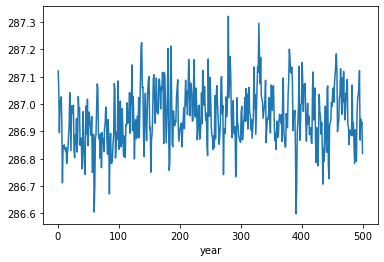

In [21]:
ESM3_picontrol_tas.plot()

In [93]:
piControl_rlut_df_list = []
for ism in piControl_ism_areacella_exist:
    piControl_rlut_df_list += [get_cmip6_data_gs(ism,'rlut','piControl')]

getting NCC_NorCPM1_r2i1p1f1
got NCC_NorCPM1_r2i1p1f1
getting CCCma_CanESM5_r1i1p1f1
got CCCma_CanESM5_r1i1p1f1
getting NASA-GISS_GISS-E2-1-G_r2i1p1f1
got NASA-GISS_GISS-E2-1-G_r2i1p1f1
getting CSIRO-ARCCSS_ACCESS-CM2_r1i1p1f1


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


got CSIRO-ARCCSS_ACCESS-CM2_r1i1p1f1
getting CAMS_CAMS-CSM1-0_r1i1p1f1
got CAMS_CAMS-CSM1-0_r1i1p1f1
getting NASA-GISS_GISS-E2-1-H_r1i1p3f1
No results for this request
got NASA-GISS_GISS-E2-1-H_r1i1p3f1
getting CMCC_CMCC-CM2-SR5_r1i1p1f1
No results for this request
got CMCC_CMCC-CM2-SR5_r1i1p1f1
getting EC-Earth-Consortium_EC-Earth3-Veg-LR_r1i1p1f1
No results for this request
got EC-Earth-Consortium_EC-Earth3-Veg-LR_r1i1p1f1


In [94]:
piControl_rsut_df_list = []
for ism in piControl_ism_areacella_exist:
    piControl_rsut_df_list += [get_cmip6_data_gs(ism,'rsut','piControl')]

getting NCC_NorCPM1_r2i1p1f1
got NCC_NorCPM1_r2i1p1f1
getting CCCma_CanESM5_r1i1p1f1
got CCCma_CanESM5_r1i1p1f1
getting NASA-GISS_GISS-E2-1-G_r2i1p1f1
got NASA-GISS_GISS-E2-1-G_r2i1p1f1
getting CSIRO-ARCCSS_ACCESS-CM2_r1i1p1f1


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


got CSIRO-ARCCSS_ACCESS-CM2_r1i1p1f1
getting CAMS_CAMS-CSM1-0_r1i1p1f1
got CAMS_CAMS-CSM1-0_r1i1p1f1
getting NASA-GISS_GISS-E2-1-H_r1i1p3f1
No results for this request
got NASA-GISS_GISS-E2-1-H_r1i1p3f1
getting CMCC_CMCC-CM2-SR5_r1i1p1f1
No results for this request
got CMCC_CMCC-CM2-SR5_r1i1p1f1
getting UA_MCM-UA-1-0_r1i1p1f1
No results for this request
got UA_MCM-UA-1-0_r1i1p1f1


In [95]:
piControl_rsdt_df_list = []
for ism in piControl_ism_areacella_exist:
    piControl_rsdt_df_list += [get_cmip6_data_gs(ism,'rsdt','piControl')]

getting NCC_NorCPM1_r2i1p1f1
got NCC_NorCPM1_r2i1p1f1
getting CCCma_CanESM5_r1i1p1f1
got CCCma_CanESM5_r1i1p1f1
getting NASA-GISS_GISS-E2-1-G_r2i1p1f1
got NASA-GISS_GISS-E2-1-G_r2i1p1f1
getting CSIRO-ARCCSS_ACCESS-CM2_r1i1p1f1


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


got CSIRO-ARCCSS_ACCESS-CM2_r1i1p1f1
getting CAMS_CAMS-CSM1-0_r1i1p1f1
got CAMS_CAMS-CSM1-0_r1i1p1f1
getting NASA-GISS_GISS-E2-1-H_r1i1p3f1
No results for this request
got NASA-GISS_GISS-E2-1-H_r1i1p3f1
getting CMCC_CMCC-CM2-SR5_r1i1p1f1
No results for this request
got CMCC_CMCC-CM2-SR5_r1i1p1f1
getting EC-Earth-Consortium_EC-Earth3-Veg-LR_r1i1p1f1
No results for this request
got EC-Earth-Consortium_EC-Earth3-Veg-LR_r1i1p1f1
getting UA_MCM-UA-1-0_r1i1p1f1
No results for this request
got UA_MCM-UA-1-0_r1i1p1f1


In [73]:
abrutp4x_tas_df_list = []
for ism in abrupt_4x_ism_areacella_exist:
    abrutp4x_tas_df_list += [get_cmip6_data_gs(ism,'tas','abrupt-4xCO2')]

getting IPSL_IPSL-CM6A-LR_r3i1p1f1
got IPSL_IPSL-CM6A-LR_r3i1p1f1
getting CCCma_CanESM5_r1i1p1f1
got CCCma_CanESM5_r1i1p1f1
getting CNRM-CERFACS_CNRM-CM6-1_r6i1p1f2
got CNRM-CERFACS_CNRM-CM6-1_r6i1p1f2
getting CNRM-CERFACS_CNRM-ESM2-1_r3i1p1f2
got CNRM-CERFACS_CNRM-ESM2-1_r3i1p1f2
getting CSIRO-ARCCSS_ACCESS-CM2_r1i1p1f1


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


got CSIRO-ARCCSS_ACCESS-CM2_r1i1p1f1
getting CAMS_CAMS-CSM1-0_r1i1p1f1
got CAMS_CAMS-CSM1-0_r1i1p1f1
getting IPSL_IPSL-CM6A-LR_r2i1p1f1
got IPSL_IPSL-CM6A-LR_r2i1p1f1
getting IPSL_IPSL-CM6A-LR_r6i1p1f1
got IPSL_IPSL-CM6A-LR_r6i1p1f1
getting IPSL_IPSL-CM6A-LR_r9i1p1f1
got IPSL_IPSL-CM6A-LR_r9i1p1f1
getting NASA-GISS_GISS-E2-1-G_r1i1p1f3
got NASA-GISS_GISS-E2-1-G_r1i1p1f3
getting NOAA-GFDL_GFDL-ESM4_r1i1p1f1
got NOAA-GFDL_GFDL-ESM4_r1i1p1f1
getting MRI_MRI-ESM2-0_r11i1p1f1
got MRI_MRI-ESM2-0_r11i1p1f1
getting MRI_MRI-ESM2-0_r3i1p1f1
got MRI_MRI-ESM2-0_r3i1p1f1
getting CNRM-CERFACS_CNRM-CM6-1_r3i1p1f2
got CNRM-CERFACS_CNRM-CM6-1_r3i1p1f2
getting MPI-M_MPI-ESM1-2-HR_r1i1p1f1
got MPI-M_MPI-ESM1-2-HR_r1i1p1f1
getting MRI_MRI-ESM2-0_r6i1p1f1
got MRI_MRI-ESM2-0_r6i1p1f1
getting E3SM-Project_E3SM-1-0_r1i1p1f1
got E3SM-Project_E3SM-1-0_r1i1p1f1
getting IPSL_IPSL-CM6A-LR_r10i1p1f1
got IPSL_IPSL-CM6A-LR_r10i1p1f1
getting MRI_MRI-ESM2-0_r1i2p1f1
got MRI_MRI-ESM2-0_r1i2p1f1
getting MRI_MRI-ESM2-0_r1

/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


got CSIRO_ACCESS-ESM1-5_r1i1p1f1
getting MIROC_MIROC6_r1i1p1f1


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


got MIROC_MIROC6_r1i1p1f1
getting MRI_MRI-ESM2-0_r13i1p1f1
got MRI_MRI-ESM2-0_r13i1p1f1
getting MRI_MRI-ESM2-0_r10i1p1f1
got MRI_MRI-ESM2-0_r10i1p1f1
getting NCAR_CESM2_r1i1p1f1
got NCAR_CESM2_r1i1p1f1
getting CNRM-CERFACS_CNRM-CM6-1_r2i1p1f2
got CNRM-CERFACS_CNRM-CM6-1_r2i1p1f2
getting MRI_MRI-ESM2-0_r1i1p1f1
got MRI_MRI-ESM2-0_r1i1p1f1
getting MPI-M_MPI-ESM1-2-LR_r1i1p1f1
got MPI-M_MPI-ESM1-2-LR_r1i1p1f1
getting NASA-GISS_GISS-E2-1-H_r1i1p1f1
got NASA-GISS_GISS-E2-1-H_r1i1p1f1
getting CNRM-CERFACS_CNRM-CM6-1-HR_r1i1p1f2
got CNRM-CERFACS_CNRM-CM6-1-HR_r1i1p1f2
getting MOHC_HadGEM3-GC31-LL_r1i1p1f3
got MOHC_HadGEM3-GC31-LL_r1i1p1f3
getting NCC_NorESM2-LM_r1i1p1f1
got NCC_NorESM2-LM_r1i1p1f1
getting MRI_MRI-ESM2-0_r4i1p1f1
got MRI_MRI-ESM2-0_r4i1p1f1
getting IPSL_IPSL-CM6A-LR_r12i1p1f1
got IPSL_IPSL-CM6A-LR_r12i1p1f1
getting MOHC_HadGEM3-GC31-MM_r1i1p1f3
got MOHC_HadGEM3-GC31-MM_r1i1p1f3
getting BCC_BCC-ESM1_r1i1p1f1
got BCC_BCC-ESM1_r1i1p1f1
getting CNRM-CERFACS_CNRM-CM6-1_r5i1p1f2
got

In [77]:
abrutp4x_rlut_df_list = []
for ism in abrupt_4x_ism_areacella_exist:
    abrutp4x_rlut_df_list += [get_cmip6_data_gs(ism,'rlut','abrupt-4xCO2')]

getting IPSL_IPSL-CM6A-LR_r3i1p1f1
got IPSL_IPSL-CM6A-LR_r3i1p1f1
getting CCCma_CanESM5_r1i1p1f1
got CCCma_CanESM5_r1i1p1f1
getting CNRM-CERFACS_CNRM-CM6-1_r6i1p1f2
got CNRM-CERFACS_CNRM-CM6-1_r6i1p1f2
getting CNRM-CERFACS_CNRM-ESM2-1_r3i1p1f2
got CNRM-CERFACS_CNRM-ESM2-1_r3i1p1f2
getting CSIRO-ARCCSS_ACCESS-CM2_r1i1p1f1


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


got CSIRO-ARCCSS_ACCESS-CM2_r1i1p1f1
getting CAMS_CAMS-CSM1-0_r1i1p1f1
got CAMS_CAMS-CSM1-0_r1i1p1f1
getting IPSL_IPSL-CM6A-LR_r2i1p1f1
got IPSL_IPSL-CM6A-LR_r2i1p1f1
getting IPSL_IPSL-CM6A-LR_r6i1p1f1
got IPSL_IPSL-CM6A-LR_r6i1p1f1
getting IPSL_IPSL-CM6A-LR_r9i1p1f1
got IPSL_IPSL-CM6A-LR_r9i1p1f1
getting NASA-GISS_GISS-E2-1-G_r1i1p1f3
got NASA-GISS_GISS-E2-1-G_r1i1p1f3
getting NOAA-GFDL_GFDL-ESM4_r1i1p1f1
got NOAA-GFDL_GFDL-ESM4_r1i1p1f1
getting MRI_MRI-ESM2-0_r11i1p1f1
got MRI_MRI-ESM2-0_r11i1p1f1
getting MRI_MRI-ESM2-0_r3i1p1f1
got MRI_MRI-ESM2-0_r3i1p1f1
getting CNRM-CERFACS_CNRM-CM6-1_r3i1p1f2
got CNRM-CERFACS_CNRM-CM6-1_r3i1p1f2
getting MPI-M_MPI-ESM1-2-HR_r1i1p1f1
got MPI-M_MPI-ESM1-2-HR_r1i1p1f1
getting MRI_MRI-ESM2-0_r6i1p1f1
got MRI_MRI-ESM2-0_r6i1p1f1
getting E3SM-Project_E3SM-1-0_r1i1p1f1
got E3SM-Project_E3SM-1-0_r1i1p1f1
getting IPSL_IPSL-CM6A-LR_r10i1p1f1
got IPSL_IPSL-CM6A-LR_r10i1p1f1
getting MRI_MRI-ESM2-0_r1i2p1f1
got MRI_MRI-ESM2-0_r1i2p1f1
getting MRI_MRI-ESM2-0_r1

/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


got IPSL_IPSL-CM6A-LR_r1i1p1f1
getting MIROC_MIROC-ES2L_r1i1p1f2
got MIROC_MIROC-ES2L_r1i1p1f2
getting NOAA-GFDL_GFDL-CM4_r1i1p1f1
got NOAA-GFDL_GFDL-CM4_r1i1p1f1
getting INM_INM-CM5-0_r1i1p1f1
got INM_INM-CM5-0_r1i1p1f1
getting IPSL_IPSL-CM6A-LR_r5i1p1f1
got IPSL_IPSL-CM6A-LR_r5i1p1f1
getting CSIRO_ACCESS-ESM1-5_r1i1p1f1


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


got CSIRO_ACCESS-ESM1-5_r1i1p1f1
getting MIROC_MIROC6_r1i1p1f1


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


got MIROC_MIROC6_r1i1p1f1
getting MRI_MRI-ESM2-0_r13i1p1f1
got MRI_MRI-ESM2-0_r13i1p1f1
getting MRI_MRI-ESM2-0_r10i1p1f1
got MRI_MRI-ESM2-0_r10i1p1f1
getting NCAR_CESM2_r1i1p1f1
got NCAR_CESM2_r1i1p1f1
getting CNRM-CERFACS_CNRM-CM6-1_r2i1p1f2
got CNRM-CERFACS_CNRM-CM6-1_r2i1p1f2
getting MRI_MRI-ESM2-0_r1i1p1f1
got MRI_MRI-ESM2-0_r1i1p1f1
getting MPI-M_MPI-ESM1-2-LR_r1i1p1f1
got MPI-M_MPI-ESM1-2-LR_r1i1p1f1
getting NASA-GISS_GISS-E2-1-H_r1i1p1f1
got NASA-GISS_GISS-E2-1-H_r1i1p1f1
getting CNRM-CERFACS_CNRM-CM6-1-HR_r1i1p1f2
got CNRM-CERFACS_CNRM-CM6-1-HR_r1i1p1f2
getting MOHC_HadGEM3-GC31-LL_r1i1p1f3
got MOHC_HadGEM3-GC31-LL_r1i1p1f3
getting NCC_NorESM2-LM_r1i1p1f1
got NCC_NorESM2-LM_r1i1p1f1
getting MRI_MRI-ESM2-0_r4i1p1f1
got MRI_MRI-ESM2-0_r4i1p1f1
getting IPSL_IPSL-CM6A-LR_r12i1p1f1
got IPSL_IPSL-CM6A-LR_r12i1p1f1
getting MOHC_HadGEM3-GC31-MM_r1i1p1f3
got MOHC_HadGEM3-GC31-MM_r1i1p1f3
getting BCC_BCC-ESM1_r1i1p1f1
got BCC_BCC-ESM1_r1i1p1f1
getting CNRM-CERFACS_CNRM-CM6-1_r5i1p1f2
got

In [75]:
abrutp4x_rsut_df_list = []
for ism in abrupt_4x_ism_areacella_exist:
    abrutp4x_rsut_df_list += [get_cmip6_data_gs(ism,'rsut','abrupt-4xCO2')]

getting IPSL_IPSL-CM6A-LR_r3i1p1f1
got IPSL_IPSL-CM6A-LR_r3i1p1f1
getting CCCma_CanESM5_r1i1p1f1
got CCCma_CanESM5_r1i1p1f1
getting CNRM-CERFACS_CNRM-CM6-1_r6i1p1f2
got CNRM-CERFACS_CNRM-CM6-1_r6i1p1f2
getting CNRM-CERFACS_CNRM-ESM2-1_r3i1p1f2
got CNRM-CERFACS_CNRM-ESM2-1_r3i1p1f2
getting CSIRO-ARCCSS_ACCESS-CM2_r1i1p1f1


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


got CSIRO-ARCCSS_ACCESS-CM2_r1i1p1f1
getting CAMS_CAMS-CSM1-0_r1i1p1f1
got CAMS_CAMS-CSM1-0_r1i1p1f1
getting IPSL_IPSL-CM6A-LR_r2i1p1f1
got IPSL_IPSL-CM6A-LR_r2i1p1f1
getting IPSL_IPSL-CM6A-LR_r6i1p1f1
got IPSL_IPSL-CM6A-LR_r6i1p1f1
getting IPSL_IPSL-CM6A-LR_r9i1p1f1
got IPSL_IPSL-CM6A-LR_r9i1p1f1
getting NASA-GISS_GISS-E2-1-G_r1i1p1f3
got NASA-GISS_GISS-E2-1-G_r1i1p1f3
getting NOAA-GFDL_GFDL-ESM4_r1i1p1f1
got NOAA-GFDL_GFDL-ESM4_r1i1p1f1
getting MRI_MRI-ESM2-0_r11i1p1f1
got MRI_MRI-ESM2-0_r11i1p1f1
getting MRI_MRI-ESM2-0_r3i1p1f1
got MRI_MRI-ESM2-0_r3i1p1f1
getting CNRM-CERFACS_CNRM-CM6-1_r3i1p1f2
got CNRM-CERFACS_CNRM-CM6-1_r3i1p1f2
getting MPI-M_MPI-ESM1-2-HR_r1i1p1f1
got MPI-M_MPI-ESM1-2-HR_r1i1p1f1
getting MRI_MRI-ESM2-0_r6i1p1f1
got MRI_MRI-ESM2-0_r6i1p1f1
getting E3SM-Project_E3SM-1-0_r1i1p1f1
got E3SM-Project_E3SM-1-0_r1i1p1f1
getting IPSL_IPSL-CM6A-LR_r10i1p1f1
got IPSL_IPSL-CM6A-LR_r10i1p1f1
getting MRI_MRI-ESM2-0_r1i2p1f1
got MRI_MRI-ESM2-0_r1i2p1f1
getting MRI_MRI-ESM2-0_r1

/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


got CSIRO_ACCESS-ESM1-5_r1i1p1f1
getting MIROC_MIROC6_r1i1p1f1


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


got MIROC_MIROC6_r1i1p1f1
getting MRI_MRI-ESM2-0_r13i1p1f1
got MRI_MRI-ESM2-0_r13i1p1f1
getting MRI_MRI-ESM2-0_r10i1p1f1
got MRI_MRI-ESM2-0_r10i1p1f1
getting NCAR_CESM2_r1i1p1f1
got NCAR_CESM2_r1i1p1f1
getting CNRM-CERFACS_CNRM-CM6-1_r2i1p1f2
got CNRM-CERFACS_CNRM-CM6-1_r2i1p1f2
getting MRI_MRI-ESM2-0_r1i1p1f1
got MRI_MRI-ESM2-0_r1i1p1f1
getting MPI-M_MPI-ESM1-2-LR_r1i1p1f1
got MPI-M_MPI-ESM1-2-LR_r1i1p1f1
getting NASA-GISS_GISS-E2-1-H_r1i1p1f1
got NASA-GISS_GISS-E2-1-H_r1i1p1f1
getting CNRM-CERFACS_CNRM-CM6-1-HR_r1i1p1f2
got CNRM-CERFACS_CNRM-CM6-1-HR_r1i1p1f2
getting MOHC_HadGEM3-GC31-LL_r1i1p1f3
got MOHC_HadGEM3-GC31-LL_r1i1p1f3
getting NCC_NorESM2-LM_r1i1p1f1
got NCC_NorESM2-LM_r1i1p1f1
getting MRI_MRI-ESM2-0_r4i1p1f1
got MRI_MRI-ESM2-0_r4i1p1f1
getting IPSL_IPSL-CM6A-LR_r12i1p1f1
got IPSL_IPSL-CM6A-LR_r12i1p1f1
getting MOHC_HadGEM3-GC31-MM_r1i1p1f3
got MOHC_HadGEM3-GC31-MM_r1i1p1f3
getting BCC_BCC-ESM1_r1i1p1f1
got BCC_BCC-ESM1_r1i1p1f1
getting CNRM-CERFACS_CNRM-CM6-1_r5i1p1f2
got

In [76]:
abrutp4x_rsdt_df_list = []
for ism in abrupt_4x_ism_areacella_exist:
    abrutp4x_rsdt_df_list += [get_cmip6_data_gs(ism,'rsdt','abrupt-4xCO2')]

getting IPSL_IPSL-CM6A-LR_r3i1p1f1
got IPSL_IPSL-CM6A-LR_r3i1p1f1
getting CCCma_CanESM5_r1i1p1f1
got CCCma_CanESM5_r1i1p1f1
getting CNRM-CERFACS_CNRM-CM6-1_r6i1p1f2
got CNRM-CERFACS_CNRM-CM6-1_r6i1p1f2
getting CNRM-CERFACS_CNRM-ESM2-1_r3i1p1f2
got CNRM-CERFACS_CNRM-ESM2-1_r3i1p1f2
getting CSIRO-ARCCSS_ACCESS-CM2_r1i1p1f1


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


got CSIRO-ARCCSS_ACCESS-CM2_r1i1p1f1
getting CAMS_CAMS-CSM1-0_r1i1p1f1
got CAMS_CAMS-CSM1-0_r1i1p1f1
getting IPSL_IPSL-CM6A-LR_r2i1p1f1
got IPSL_IPSL-CM6A-LR_r2i1p1f1
getting IPSL_IPSL-CM6A-LR_r6i1p1f1
got IPSL_IPSL-CM6A-LR_r6i1p1f1
getting IPSL_IPSL-CM6A-LR_r9i1p1f1
got IPSL_IPSL-CM6A-LR_r9i1p1f1
getting NASA-GISS_GISS-E2-1-G_r1i1p1f3
got NASA-GISS_GISS-E2-1-G_r1i1p1f3
getting NOAA-GFDL_GFDL-ESM4_r1i1p1f1
got NOAA-GFDL_GFDL-ESM4_r1i1p1f1
getting MRI_MRI-ESM2-0_r11i1p1f1
got MRI_MRI-ESM2-0_r11i1p1f1
getting MRI_MRI-ESM2-0_r3i1p1f1
got MRI_MRI-ESM2-0_r3i1p1f1
getting CNRM-CERFACS_CNRM-CM6-1_r3i1p1f2
got CNRM-CERFACS_CNRM-CM6-1_r3i1p1f2
getting MPI-M_MPI-ESM1-2-HR_r1i1p1f1
got MPI-M_MPI-ESM1-2-HR_r1i1p1f1
getting MRI_MRI-ESM2-0_r6i1p1f1
got MRI_MRI-ESM2-0_r6i1p1f1
getting E3SM-Project_E3SM-1-0_r1i1p1f1
got E3SM-Project_E3SM-1-0_r1i1p1f1
getting IPSL_IPSL-CM6A-LR_r10i1p1f1
got IPSL_IPSL-CM6A-LR_r10i1p1f1
getting MRI_MRI-ESM2-0_r1i2p1f1
got MRI_MRI-ESM2-0_r1i2p1f1
getting MRI_MRI-ESM2-0_r1

/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


got CSIRO_ACCESS-ESM1-5_r1i1p1f1
getting MIROC_MIROC6_r1i1p1f1


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


got MIROC_MIROC6_r1i1p1f1
getting MRI_MRI-ESM2-0_r13i1p1f1
got MRI_MRI-ESM2-0_r13i1p1f1
getting MRI_MRI-ESM2-0_r10i1p1f1
got MRI_MRI-ESM2-0_r10i1p1f1
getting NCAR_CESM2_r1i1p1f1
got NCAR_CESM2_r1i1p1f1
getting CNRM-CERFACS_CNRM-CM6-1_r2i1p1f2
got CNRM-CERFACS_CNRM-CM6-1_r2i1p1f2
getting MRI_MRI-ESM2-0_r1i1p1f1
got MRI_MRI-ESM2-0_r1i1p1f1
getting MPI-M_MPI-ESM1-2-LR_r1i1p1f1
got MPI-M_MPI-ESM1-2-LR_r1i1p1f1
getting NASA-GISS_GISS-E2-1-H_r1i1p1f1
got NASA-GISS_GISS-E2-1-H_r1i1p1f1
getting CNRM-CERFACS_CNRM-CM6-1-HR_r1i1p1f2
got CNRM-CERFACS_CNRM-CM6-1-HR_r1i1p1f2
getting MOHC_HadGEM3-GC31-LL_r1i1p1f3
got MOHC_HadGEM3-GC31-LL_r1i1p1f3
getting NCC_NorESM2-LM_r1i1p1f1
got NCC_NorESM2-LM_r1i1p1f1
getting MRI_MRI-ESM2-0_r4i1p1f1
got MRI_MRI-ESM2-0_r4i1p1f1
getting IPSL_IPSL-CM6A-LR_r12i1p1f1
got IPSL_IPSL-CM6A-LR_r12i1p1f1
getting MOHC_HadGEM3-GC31-MM_r1i1p1f3
got MOHC_HadGEM3-GC31-MM_r1i1p1f3
getting BCC_BCC-ESM1_r1i1p1f1
got BCC_BCC-ESM1_r1i1p1f1
getting CNRM-CERFACS_CNRM-CM6-1_r5i1p1f2
got

In [80]:
abrutp4x_rsdt_df = pd.concat(abrutp4x_rsdt_df_list,axis=1)
abrutp4x_rsut_df = pd.concat(abrutp4x_rsut_df_list,axis=1)
abrutp4x_rlut_df = pd.concat(abrutp4x_rlut_df_list,axis=1)
abrutp4x_tas_df = pd.concat(abrutp4x_tas_df_list,axis=1)
piControl_tas_df = pd.concat(piControl_df_list,axis=1)
piControl_rsdt_df = pd.concat(piControl_rsdt_df_list,axis=1)
piControl_rsut_df = pd.concat(piControl_rsut_df_list,axis=1)
piControl_rlut_df = pd.concat(piControl_rlut_df_list,axis=1)
onepct_tas_df = pd.concat(onepct_tas_df_list,axis=1)
onepct_rlut_df = pd.concat(onepct_rlut_df_list,axis=1)
onepct_rsut_df = pd.concat(onepct_rsut_df_list,axis=1)
onepct_rsdt_df = pd.concat(onepct_rsdt_df_list,axis=1)
onepct_co2mass_df = pd.concat(onepct_co2mass_df_list,axis=1)

# onepct_co2mass_df.to_csv('./cmip6_data/onepct_co2mass.csv')
# onepct_tas_df.to_csv('./cmip6_data/onepct_tas.csv')
# onepct_rlut_df.to_csv('./cmip6_data/onepct_rlut.csv')
# onepct_rsut_df.to_csv('./cmip6_data/onepct_rsut.csv')
# onepct_rsdt_df.to_csv('./cmip6_data/onepct_rsdt.csv')
# piControl_rlut_df.to_csv('./cmip6_data/piControl_rlut.csv')
# piControl_rsut_df.to_csv('./cmip6_data/piControl_rsut.csv')
# piControl_rsdt_df.to_csv('./cmip6_data/piControl_rsdt.csv')
# abrutp4x_rsdt_df.to_csv('./cmip6_data/abrupt-4xCO2_rsdt.csv')
# abrutp4x_rsut_df.to_csv('./cmip6_data/abrupt-4xCO2_rsut.csv')
# abrutp4x_rlut_df.to_csv('./cmip6_data/abrupt-4xCO2_rlut.csv')
# abrutp4x_tas_df.to_csv('./cmip6_data/abrupt-4xCO2_tas.csv')
# piControl_tas_df.to_csv('./cmip6_data/piControl_tas.csv')

In [74]:
def get_annual_CMIP6_data_esgf(activity, table, variable, experiment, institution, source, member):
    # eg activity='CMIP', table='Amon', variable='tas', experiment='historical', institution="NCAR", source="CESM2", member="r10i1p1f1"
    
    result = esgf_search(activity_id=activity, table_id=table, variable_id=variable, experiment_id=experiment,institution_id=institution, source_id=source, member_id=member)
    
    if not result:
        print('No results for this request')
        return None
    
    # select results with only the latest datestamp:
    latest = sorted([x.split('/')[15] for x in result])[-1]
    result = [x for x in result if x.split('/')[15]==latest]
    
    # remove duplicate results
    result_1 = []

    for item in result:
        if item.split('/')[-1] in [x.split('/')[-1] for x in result_1]:
            continue
        else:
            result_1 += [item]

    ds = xr.open_mfdataset(result_1, combine='by_coords')
    
    files_area = esgf_search(variable_id='areacella', activity_id=activity, institution_id=institution, source_id=source)
    
    if not files_area:
        print('No areacella for this request')
        return None
    
    ds_area = xr.open_dataset(files_area[0])
    
    coords = list(ds[variable].coords.keys())
    if 'lat' in coords:
        dims = ['lat','lon']
    else:
        dims = ['latitude','longitude']
    
    total_area = ds_area.areacella.sum(dim=dims)
    ta_timeseries = (ds[variable] * ds_area.areacella).sum(dim=dims) / total_area
    
    return ta_timeseries.groupby('time.year').mean('time').to_pandas().rename(institution+'_'+source+'_'+member)

In [24]:
def get_annual_CMIP6_data_esgf_multivar(activity, table, variables, experiment, institution, source, member):
    # eg activity='CMIP', table='Amon', variable='tas', experiment='historical', institution="NCAR", source="CESM2", member="r10i1p1f1"
    
    result = esgf_search(activity_id=activity, table_id=table, experiment_id=experiment,institution_id=institution, source_id=source, member_id=member)
    
    result = [x for x in result if x.split('/')[13] in variables]
    
    if not result:
        print('No results for this request')
        return None
    
    # select results with only the latest datestamp:
#     latest = sorted([x.split('/')[15] for x in result])[-1]
#     result = [x for x in result if x.split('/')[15]==latest]
    
    # remove duplicate results
    result_1 = []

    for item in result:
        if item.split('/')[-1] in [x.split('/')[-1] for x in result_1]:
            continue
        else:
            result_1 += [item]

    ds = xr.open_mfdataset(result_1, combine='by_coords')
    
    files_area = esgf_search(variable_id='areacella', activity_id=activity, institution_id=institution, source_id=source)
    
    if not files_area:
        print('No areacella for this request')
        return None
    
    ds_area = xr.open_dataset(files_area[0])
    
    coords = list(ds[variables].coords.keys())
    if 'lat' in coords:
        dims = ['lat','lon']
    else:
        dims = ['latitude','longitude']
    
    total_area = ds_area.areacella.sum(dim=dims)
    ta_timeseries = (ds[variables] * ds_area.areacella).sum(dim=dims) / total_area
    
    _out = ta_timeseries.groupby('time.year').mean('time').to_dataframe()[variables]
    
    return pd.concat([_out],axis=1,keys=[institution+'_'+source+'_'+member])

In [5]:
piControl_list = esgf_search(activity_id='CMIP', table_id='Amon', variable_id='tas', experiment_id='piControl')
piControl_list_nodupl = []

for item in piControl_list:
    if item.split('/')[-1] in [x.split('/')[-1] for x in piControl_list_nodupl]:
        continue
    else:
        piControl_list_nodupl += [item]
        
abrupt4x_list = esgf_search(activity_id='CMIP', table_id='Amon', variable_id='tas', experiment_id='abrupt-4xCO2')
abrupt4x_list_nodupl = []

for item in abrupt4x_list:
    if item.split('/')[-1] in [x.split('/')[-1] for x in abrupt4x_list_nodupl]:
        continue
    else:
        abrupt4x_list_nodupl += [item]
        
areacella_list = esgf_search(activity_id='CMIP', variable_id='areacella')
areacella_list_nodupl = []

for item in areacella_list:
    if item.split('/')[-1] in [x.split('/')[-1] for x in areacella_list_nodupl]:
        continue
    else:
        areacella_list_nodupl += [item]
        
abrupt4x_ism_list = list(set([x.split('/')[8]+'_'+x.split('/')[9]+'_'+x.split('/')[11] for x in abrupt4x_list_nodupl]))
piControl_ism_list = list(set([x.split('/')[8]+'_'+x.split('/')[9]+'_'+x.split('/')[11] for x in piControl_list_nodupl]))
areacella_ism_list = list(set([x.split('/')[8]+'_'+x.split('/')[9]+'_'+x.split('/')[11] for x in areacella_list_nodupl]))
areacella_s_list = list(set([x.split('_')[1] for x in areacella_ism_list]))

piControl_ism_areacella_exist = [x for x in piControl_ism_list if x.split('_')[1] in areacella_s_list]
abrupt4x_ism_areacella_exist = [x for x in abrupt4x_ism_list if x.split('_')[1] in areacella_s_list]

In [14]:
abrupt4x_tas_df = pd.read_csv('./cmip6_data/abrupt-4xCO2_tas.csv',index_col=0)
esgf_abrupt4x_list = [x for x in abrupt4x_ism_areacella_exist if not x in abrupt4x_tas_df.columns]

piControl_tas_df = pd.read_csv('./cmip6_data/piControl_tas.csv',index_col=0)
esgf_piControl_list = [x for x in piControl_ism_areacella_exist if not x in piControl_tas_df.columns]

In [20]:
def get_CMIP6_data(ism,exp='abrupt-4xCO2',var='tas',multivar=False):
    ism_split = ism.split('_')
    if multivar:
        _out = get_annual_CMIP6_data_esgf_multivar('CMIP', 'Amon', var, exp, ism_split[0], ism_split[1], ism_split[2])
    else:
        _out = get_annual_CMIP6_data_esgf('CMIP', 'Amon', var, exp, ism_split[0], ism_split[1], ism_split[2])
    print(ism+' complete')
    return _out

In [25]:
# abrupt4x_df_list_esgf = []
for x in esgf_abrupt4x_list:
    abrupt4x_df_list_esgf += [get_CMIP6_data(x,'abrupt-4xCO2',['tas','rlut','rsut','rsdt'],True)]
# P1=multiprocessing.Pool(processes=8)
# abrupt4xCO2_df = P1.starmap(get_CMIP6_data,[(x,'abrupt-4xCO2',['tas','rlut','rsut','rsdt'],True) for x in abrupt4x_ism_areacella_exist])
# P1.close

CAMS_CAMS-CSM1-0_r1i1p1f1 complete
IPSL_IPSL-CM6A-LR_r10i1p1f1 complete


/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/leachl/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/times.p

OverflowError: Python int too large to convert to C long

Exception ignored in: 'pandas._libs.algos.are_diff'
Traceback (most recent call last):
  File "/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/cftimeindex.py", line 433, in __sub__
    return pd.TimedeltaIndex(np.array(self) - np.array(other))
  File "/home/leachl/miniconda3/lib/python3.7/site-packages/pandas/core/indexes/timedeltas.py", line 258, in __new__
    data, freq=freq, unit=unit, dtype=dtype, copy=copy
  File "/home/leachl/miniconda3/lib/python3.7/site-packages/pandas/core/arrays/timedeltas.py", line 272, in _from_sequence
    data, inferred_freq = sequence_to_td64ns(data, copy=copy, unit=unit)
  File "/home/leachl/miniconda3/lib/python3.7/site-packages/pandas/core/arrays/timedeltas.py", line 973, in sequence_to_td64ns
    data = objects_to_td64ns(data, unit=unit, errors=errors)
  File "/home/leachl/miniconda3/lib/python3.7/site-packages/pandas/core/arrays/timedeltas.py", line 1098, in objects_to_td64ns
    result = array_to_timedelta64(values, unit=unit, er

OverflowError: Python int too large to convert to C long

Exception ignored in: 'pandas._libs.algos.are_diff'
Traceback (most recent call last):
  File "/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/cftimeindex.py", line 433, in __sub__
    return pd.TimedeltaIndex(np.array(self) - np.array(other))
  File "/home/leachl/miniconda3/lib/python3.7/site-packages/pandas/core/indexes/timedeltas.py", line 258, in __new__
    data, freq=freq, unit=unit, dtype=dtype, copy=copy
  File "/home/leachl/miniconda3/lib/python3.7/site-packages/pandas/core/arrays/timedeltas.py", line 272, in _from_sequence
    data, inferred_freq = sequence_to_td64ns(data, copy=copy, unit=unit)
  File "/home/leachl/miniconda3/lib/python3.7/site-packages/pandas/core/arrays/timedeltas.py", line 973, in sequence_to_td64ns
    data = objects_to_td64ns(data, unit=unit, errors=errors)
  File "/home/leachl/miniconda3/lib/python3.7/site-packages/pandas/core/arrays/timedeltas.py", line 1098, in objects_to_td64ns
    result = array_to_timedelta64(values, unit=unit, er

OverflowError: Python int too large to convert to C long

Exception ignored in: 'pandas._libs.algos.are_diff'
Traceback (most recent call last):
  File "/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/cftimeindex.py", line 433, in __sub__
    return pd.TimedeltaIndex(np.array(self) - np.array(other))
  File "/home/leachl/miniconda3/lib/python3.7/site-packages/pandas/core/indexes/timedeltas.py", line 258, in __new__
    data, freq=freq, unit=unit, dtype=dtype, copy=copy
  File "/home/leachl/miniconda3/lib/python3.7/site-packages/pandas/core/arrays/timedeltas.py", line 272, in _from_sequence
    data, inferred_freq = sequence_to_td64ns(data, copy=copy, unit=unit)
  File "/home/leachl/miniconda3/lib/python3.7/site-packages/pandas/core/arrays/timedeltas.py", line 973, in sequence_to_td64ns
    data = objects_to_td64ns(data, unit=unit, errors=errors)
  File "/home/leachl/miniconda3/lib/python3.7/site-packages/pandas/core/arrays/timedeltas.py", line 1098, in objects_to_td64ns
    result = array_to_timedelta64(values, unit=unit, er

OverflowError: Python int too large to convert to C long

Exception ignored in: 'pandas._libs.algos.are_diff'
Traceback (most recent call last):
  File "/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/coding/cftimeindex.py", line 433, in __sub__
    return pd.TimedeltaIndex(np.array(self) - np.array(other))
  File "/home/leachl/miniconda3/lib/python3.7/site-packages/pandas/core/indexes/timedeltas.py", line 258, in __new__
    data, freq=freq, unit=unit, dtype=dtype, copy=copy
  File "/home/leachl/miniconda3/lib/python3.7/site-packages/pandas/core/arrays/timedeltas.py", line 272, in _from_sequence
    data, inferred_freq = sequence_to_td64ns(data, copy=copy, unit=unit)
  File "/home/leachl/miniconda3/lib/python3.7/site-packages/pandas/core/arrays/timedeltas.py", line 973, in sequence_to_td64ns
    data = objects_to_td64ns(data, unit=unit, errors=errors)
  File "/home/leachl/miniconda3/lib/python3.7/site-packages/pandas/core/arrays/timedeltas.py", line 1098, in objects_to_td64ns
    result = array_to_timedelta64(values, unit=unit, er

AttributeError: 'IndexVariable' object has no attribute 'year'

In [62]:
piControl_df_list_esgf = []
for x in piControl_ism_areacella_exist:
    piControl_df_list_esgf += [get_CMIP6_data(x,'piControl','tas')]
# P1=multiprocessing.Pool(processes=8)
# piControl_df = P1.starmap(get_CMIP6_data,[(x,'piControl','tas',False) for x in piControl_ism_areacella_exist])
# P1.close

NASA-GISS_GISS-E2-1-G_r1i1p1f2 complete
NASA-GISS_GISS-E2-1-G_r1i1p1f3 complete


RuntimeError: NetCDF: Access failure